In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.qaoa.models.MaxCutProblem import MaxCutProblem

def visualize(data, x,y, hues, chart):
    fig = plt.figure(figsize=(8,6))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
        case None:
            chart_type = sns.plot

    # make a copy to avoid modifying the original DataFrame and avoid warnings
    data_to_plot = data.copy()

    try:
        if len(hues) > 1:
            data_to_plot['hues'] = data_to_plot[hues].astype(str).agg('-'.join, axis=1)
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        elif len(hues) == 1:
            data_to_plot['hues'] = data_to_plot[hues[0]]
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            _ = chart_type(data=data_to_plot, x=x, y=y)
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
            #plt.show()

            plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

        plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
        plt.show()
        plt.close(fig)
    except (KeyError, ValueError) as e:
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data_to_plot.columns}\nException: {e}")


### Configure the results you want to visualize under.

#### Pick multiple hues with ctrl or shift + click.
#### The "Exclude bad" removes the warm started hamming distances of >0 from the dataset.


In [45]:
import ast
import numpy as np
import json

noisy_runs = pd.read_csv('runs_export.csv')
noisy_runs = noisy_runs.dropna()
noisy_runs = noisy_runs['artefact_path'].apply(json.loads)
strings = ["results/results_statevector_HD135_all.csv",
           "results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'multiangle'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{4},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{4},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{7},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{7},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv"]

""",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'multiangle'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{4},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{4},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{7},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'vanilla'},'param_initialization'{'gaussian'},'depth'{7},'warm_start'{True},'problem_type'{'minvertexcover'},'hamming_dist'{1,3,5}}.csv"]
"""
strings_lagrange = ["results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{True},'problem_type'{'minvertexcover'},'lagrangian_multiplier.csv",
"results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{False,True},'problem_type'{'minvertexcover'},'lagrangian_mult.csv"
   ]
 

for file in strings:
    try:
        df = pd.read_csv(file)
        #print(f"File: {file}")
        #print(df['graph_name'].value_counts())
        #print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path,index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0])



for file in strings_lagrange:
    try:
        df = pd.read_csv(file)
        print(f"File: {file}")
        print(df['graph_name'].value_counts())
        print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings_lagrange) >1:
    results_lagrange = pd.concat([pd.read_csv(path,index_col=0) for path in strings_lagrange])

else:
    results_lagrange = pd.read_csv(strings_lagrange[0])

results = pd.concat([results, noisy_runs])
results_lagrange = results_lagrange[((results_lagrange['qaoa_variant'] == 'multiangle') & (results_lagrange['depth'] == 1)) |
              ((results_lagrange['qaoa_variant'] == 'vanilla') & (results_lagrange['depth'] == 4))]

File: results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{True},'problem_type'{'minvertexcover'},'lagrangian_multiplier.csv
graph_name
>>graph6<<Hh_iS_u    2400
>>graph6<<HmzffJz    2400
Name: count, dtype: int64


File: results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{False,True},'problem_type'{'minvertexcover'},'lagrangian_mult.csv
graph_name
>>graph6<<HmzffJz    1600
>>graph6<<Hh_iS_u    1600
Name: count, dtype: int64




C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\3464878749.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


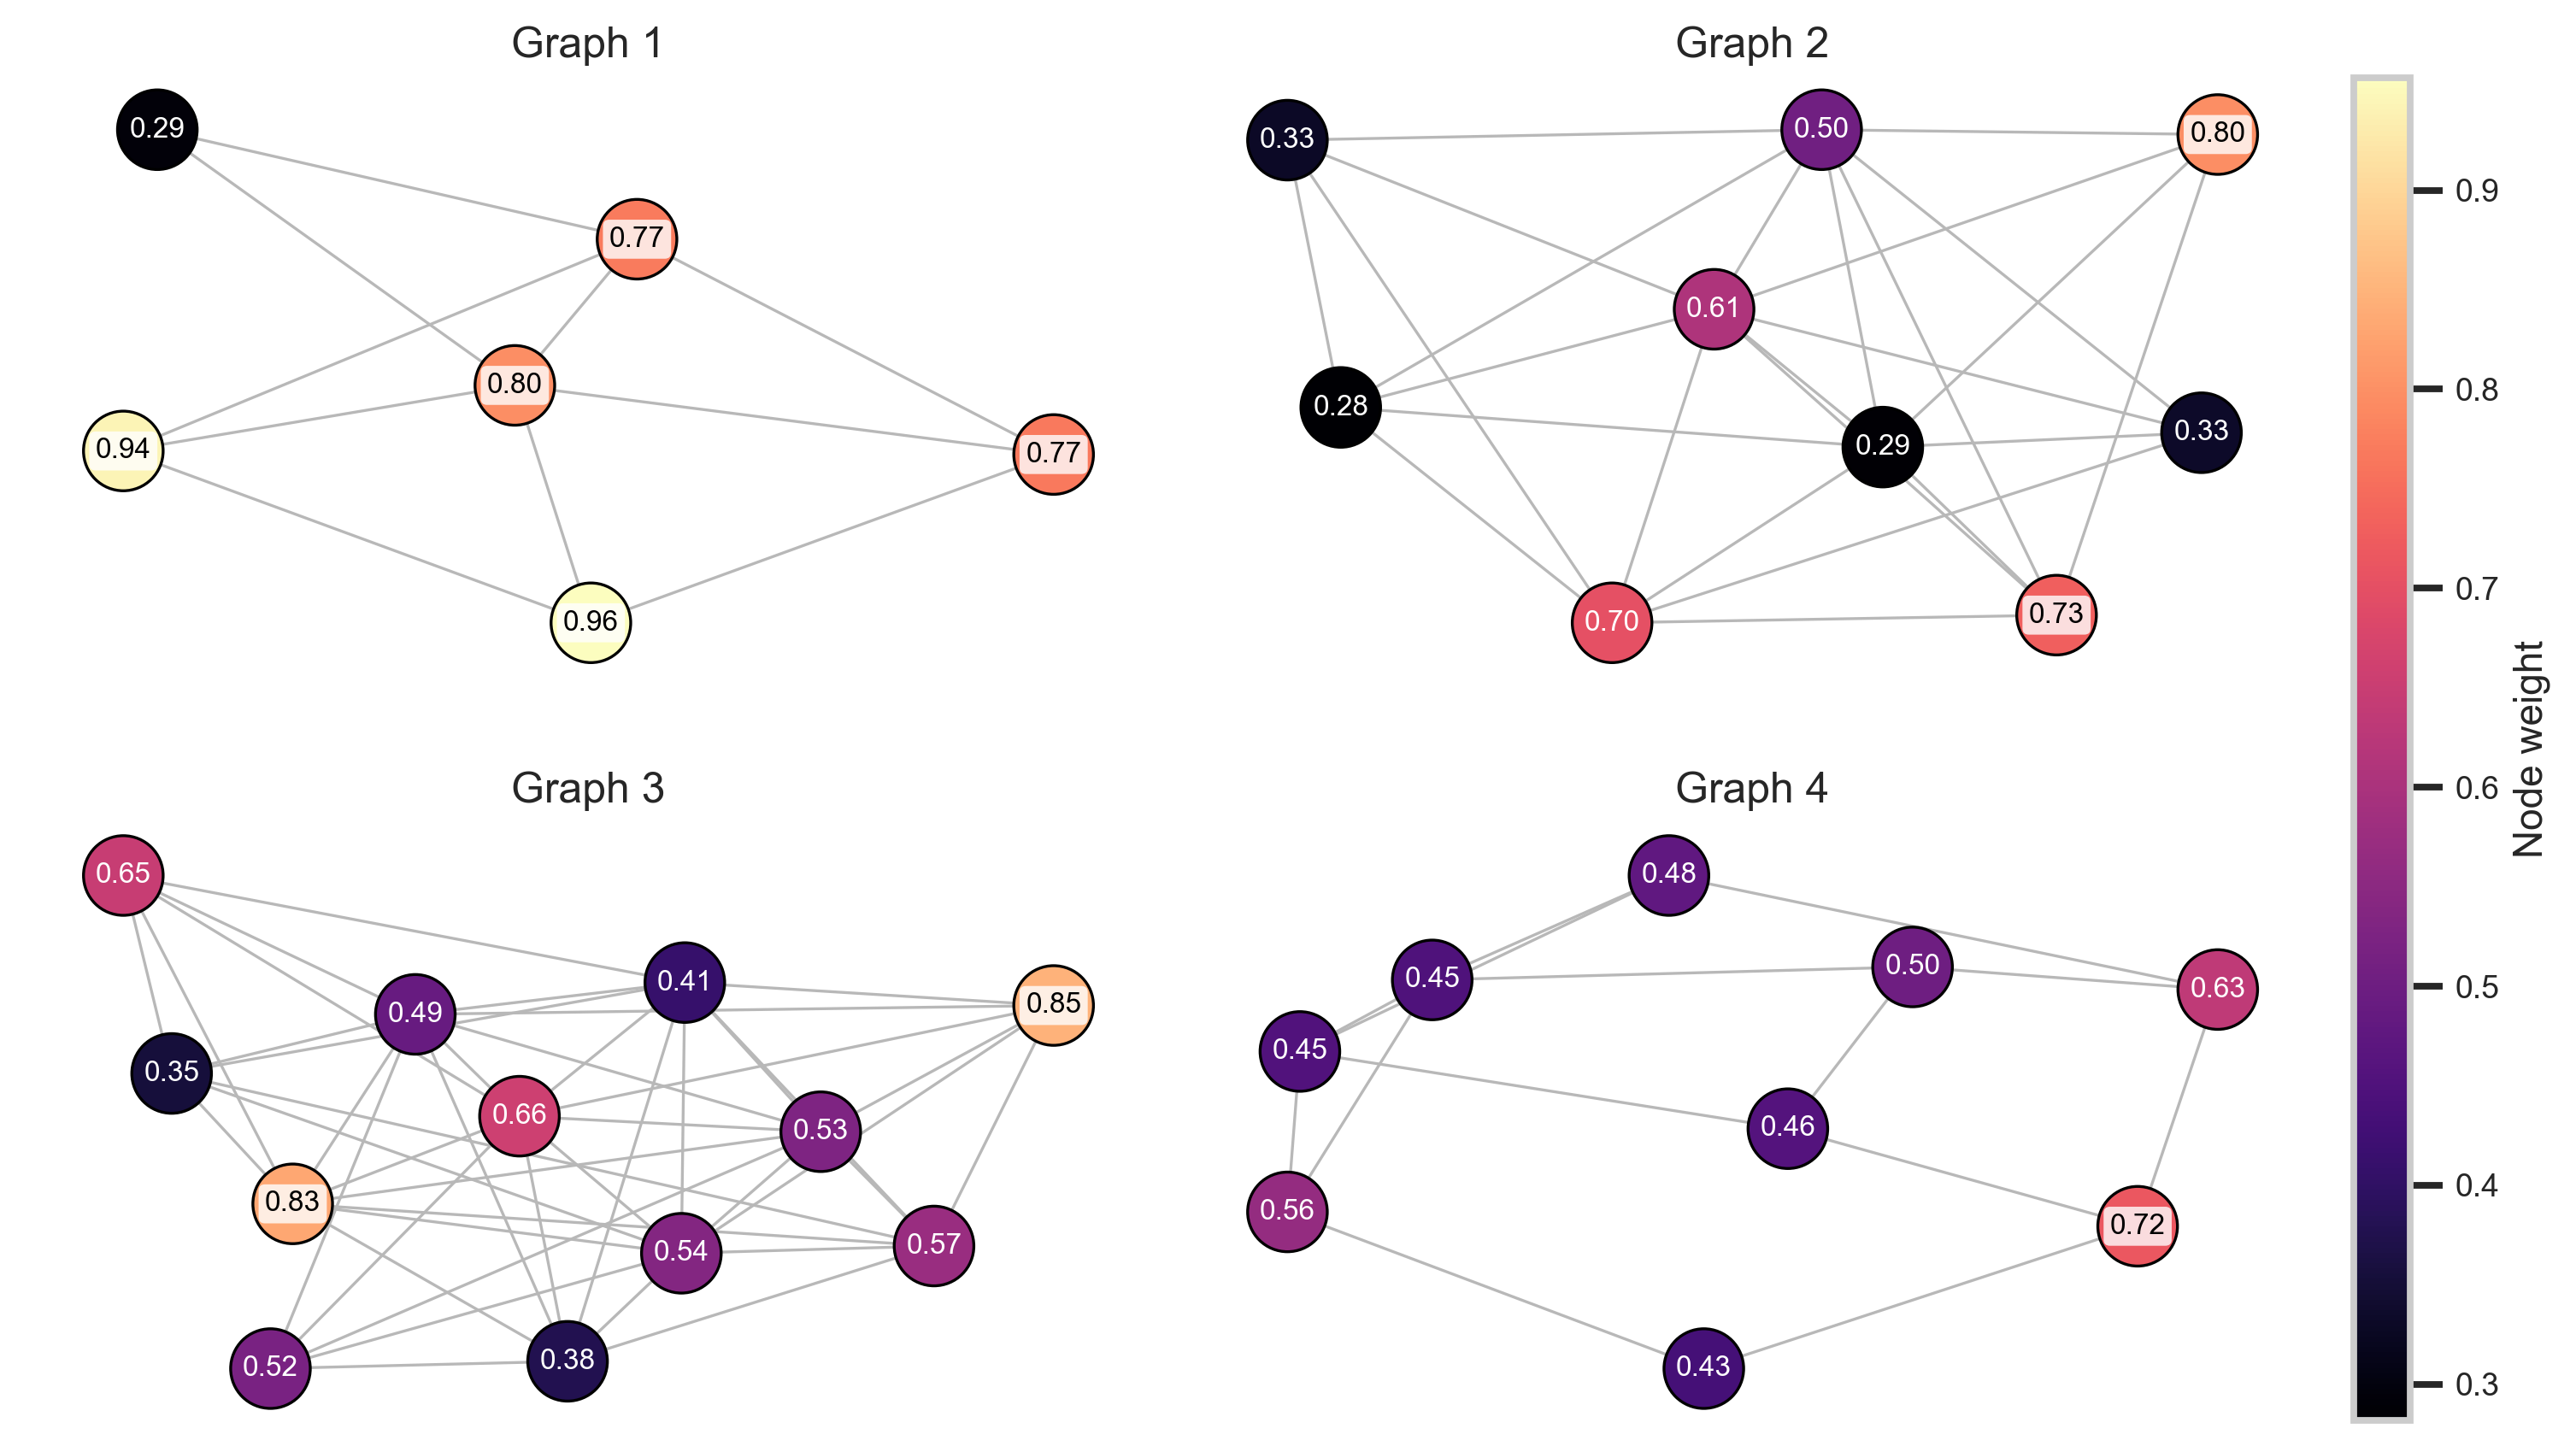

In [46]:
# ── graph_visualisation.py ──────────────────────────────────────────
"""
Generate a 2×2 panel of Erdős–Rényi graphs coloured by node weight.

▪ Requires:  matplotlib, networkx, rustworkx, numpy
▪ Run with :  python graph_visualisation.py
▪ Outputs  :  graphs_w_weights.pdf   (vector)
              graphs_w_weights.png   (hi-res raster)
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
import networkx as nx
import rustworkx as rx                    # only needed for the converter

# -------------------------------------------------------------------
# ❶  Bring / generate your problem graphs
# -------------------------------------------------------------------
from src.qaoa.models.MaxCutProblem import MaxCutProblem     # ← change to your actual import

problem = MaxCutProblem()
graphs_rx = problem.get_erdos_renyi_graphs_paper1()   # list[rx.PyGraph]

# -------------------------------------------------------------------
# ❷  Utility: Rustworkx → NetworkX
# -------------------------------------------------------------------
def rwx_to_nx(rwx_g: rx.PyGraph) -> nx.Graph:
    """Return a NetworkX clone of a rustworkx.PyGraph, preserving node weight."""
    H = nx.Graph()
    for n in rwx_g.node_indices():
        H.add_node(n, weight=rwx_g[n])
    H.add_edges_from(rwx_g.edge_list())
    return H

graphs_nx = [rwx_to_nx(g) for g in graphs_rx]

# -------------------------------------------------------------------
# ❸  Global colour normalisation
# -------------------------------------------------------------------
all_weights = [d["weight"] for G in graphs_nx for _, d in G.nodes(data=True)]
norm = colors.Normalize(vmin=min(all_weights), vmax=max(all_weights))
cmap = plt.cm.magma

# -------------------------------------------------------------------
# ❹  Build the figure: 2 × 2 panels + 1 column for colour-bar
# -------------------------------------------------------------------
fig = plt.figure(figsize=(12, 6.8), dpi=300)
gs  = gridspec.GridSpec(nrows=2, ncols=3,
                        width_ratios=[1, 1, 0.05],
                        wspace=0.05, hspace=0.25)

axes = [fig.add_subplot(gs[i//2, i % 2]) for i in range(4)]   # graph panels
cax  = fig.add_subplot(gs[:, 2])                              # colour-bar axis

# -------------------------------------------------------------------
# ❺  Draw each graph
# -------------------------------------------------------------------
for idx, (G, ax) in enumerate(zip(graphs_nx, axes)):
    weights = np.array([d["weight"] for _, d in G.nodes(data=True)])
    node_colors = cmap(norm(weights))
    pos = nx.spring_layout(G, seed=42)                        # deterministic

    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="0.72", width=0.8)

    # nodes
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_color=node_colors,
                           node_size=500,
                           linewidths=0.8,
                           edgecolors="black")

    # decide text colour from luminance
    luminance = np.dot(node_colors[:, :3], [0.2126, 0.7152, 0.0722])
    dark, light = luminance < 0.45, luminance >= 0.45
    nodes_dark  = [n for n, d in zip(G.nodes, dark) if d]
    nodes_light = [n for n, d in zip(G.nodes, light) if d]
    labels = {n: f"{w:.2f}" for n, w in zip(G.nodes, weights)}

    nx.draw_networkx_labels(
        G, pos, labels={n: labels[n] for n in nodes_light}, ax=ax,
        font_size=8, font_color="black",
        bbox=dict(boxstyle="round,pad=0.22", fc="white", ec="none", alpha=0.8))

    nx.draw_networkx_labels(
        G, pos, labels={n: labels[n] for n in nodes_dark}, ax=ax,
        font_size=8, font_color="white",
        bbox=dict(boxstyle="round,pad=0.22", fc="black", ec="none", alpha=0.0))

    ax.set_title(f"Graph {idx+1}", fontsize=12)
    ax.set_axis_off()

# -------------------------------------------------------------------
# ❻  Shared vertical colour-bar
# -------------------------------------------------------------------
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label("Node weight", fontsize=11)
cbar.ax.tick_params(labelsize=9)

# -------------------------------------------------------------------
# ❼  Finish up
# -------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig("graphs_w_weights.pdf",  bbox_inches="tight")
fig.savefig("graphs_w_weights.png",  dpi=300, bbox_inches="tight")
plt.show()


In [47]:
from src.qaoa.models.solver import MinVertexCoverSolver
import networkx as nx

graphs = problem.get_erdos_renyi_graphs_paper1()
for g in graphs:
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results['graph_name'] == graph6_string
    results.loc[results['graph_name'] == graph6_string, 'infeasible']= results.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results['graph_name'] == graph6_string) & (results['warm_start'] == True)
    results.loc[mask_ws, 'ws_value'] = results.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )
    
for g in graphs: #lagrange version
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results_lagrange['graph_name'] == graph6_string
    results_lagrange.loc[mask, 'infeasible']= results_lagrange.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results_lagrange['graph_name'] == graph6_string) & (results_lagrange['warm_start'] == True)
    results_lagrange.loc[mask_ws, 'ws_value'] = results_lagrange.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )



In [48]:
from ipywidgets import interact, interactive_output, widgets, HBox, VBox
import matplotlib.pyplot as plt
import ast, pandas as pd

# --- basic controls ----------------------------------------------------------
graph_names = ['All'] + results['graph_name'].unique().tolist()
y_options   = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x_options   = ['qaoa_variant', 'depth', 'hamming_dist', 'warm_start',
               'lagrangian_multiplier','backend_mode']
hue_options = x_options.copy()
chart_types = ['bar', 'line', 'box']
ws_options  = [False, True]

graph_dd   = widgets.Dropdown(options=graph_names,  description='Graph:')
x_dd       = widgets.Dropdown(options=x_options,     description='X axis:')
y_dd       = widgets.Dropdown(options=y_options,     description='Y axis:')
hues_ms    = widgets.SelectMultiple(options=hue_options, description='Hues:')
chart_dd   = widgets.Dropdown(options=chart_types,   description='Chart:')
ws_dd      = widgets.Dropdown(options=ws_options,    description='Exclude WS?')

# --- helper to build one "filter row" ----------------------------------------
all_cols   = results.columns.tolist()
ops        = ['>', '>=', '<', '<=', '==', '!=']

def make_filter_row(i: int):
    """Return widgets for a single filter row."""
    enable   = widgets.Checkbox(value=False, description=f'Filter {i}')
    col      = widgets.Dropdown(options=all_cols, description='Column')
    op       = widgets.Dropdown(options=ops,      description='Op')
    val      = widgets.Text(description='Value')
    return enable, col, op, val

flt1_enable, flt1_col, flt1_op, flt1_val = make_filter_row(1)
flt2_enable, flt2_col, flt2_op, flt2_val = make_filter_row(2)

filter_box = VBox([
    HBox([flt1_enable, flt1_col, flt1_op, flt1_val]),
    HBox([flt2_enable, flt2_col, flt2_op, flt2_val])
])

# --- function that actually draws -------------------------------------------
def _apply_single_filter(df, enable, col, op, val):
    """Apply one filter if `enable` is True."""
    if not enable or col not in df.columns:
        return df  # skip invalid filters

    try:
        # Try evaluating the value as a Python literal
        val = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        try:
            # Fallback: coerce to column's dtype
            val = df[col].dtype.type(val)
        except Exception:
            pass  # Leave it as-is if all else fails

    expr = f"`{col}` {op} @val"
    return df.query(expr)


def update_visualization(graph_name, x, y, hues, chart,
                         exclude_warmstart,
                         # filter-1 widgets
                         f1_en, f1_col, f1_op, f1_val,
                         # filter-2 widgets
                         f2_en, f2_col, f2_op, f2_val):
    
    # --- start with the selected graph(s) ------------------------------------
    if graph_name == 'All':

        df = results.copy() 
    else:
        df = results[results['graph_name'] == graph_name].copy()
    
    # --- built-in warm-start exclusion ---------------------------------------
    if exclude_warmstart:
        df = df[df['hamming_dist'] == 0]
    
    # --- apply the two optional filters --------------------------------------
    df = _apply_single_filter(df, f1_en, f1_col, f1_op, f1_val)
    df = _apply_single_filter(df, f2_en, f2_col, f2_op, f2_val)
    
    # --- tidy + call your plotting helper ------------------------------------
    if hues:
        df = df.sort_values(by=[x] + list(hues))
    visualize(df, x=x, y=y, hues=list(hues), chart=chart)

# --- wire everything up ------------------------------------------------------
ui = VBox([
    HBox([graph_dd, x_dd, y_dd]),
    HBox([hues_ms, chart_dd, ws_dd]),
    filter_box
])

out = interactive_output(
    update_visualization,
    {
        'graph_name': graph_dd, 'x': x_dd, 'y': y_dd, 'hues': hues_ms,
        'chart': chart_dd, 'exclude_warmstart': ws_dd,
        
        # pipe the widgets for the two filters
        'f1_en': flt1_enable, 'f1_col': flt1_col, 'f1_op': flt1_op, 'f1_val': flt1_val,
        'f2_en': flt2_enable, 'f2_col': flt2_col, 'f2_op': flt2_op, 'f2_val': flt2_val
    }
)
print(results['backend_mode'].unique())
display(ui, out)


['statevector' 'noisy_sampling']


Output()

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\2674995906.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_ws, x='time_elapsed', ax=axes[0], hue='Qubit Initialization', palette='viridis', linewidth=3,legend='full')


TypeError: 'NoneType' object is not iterable

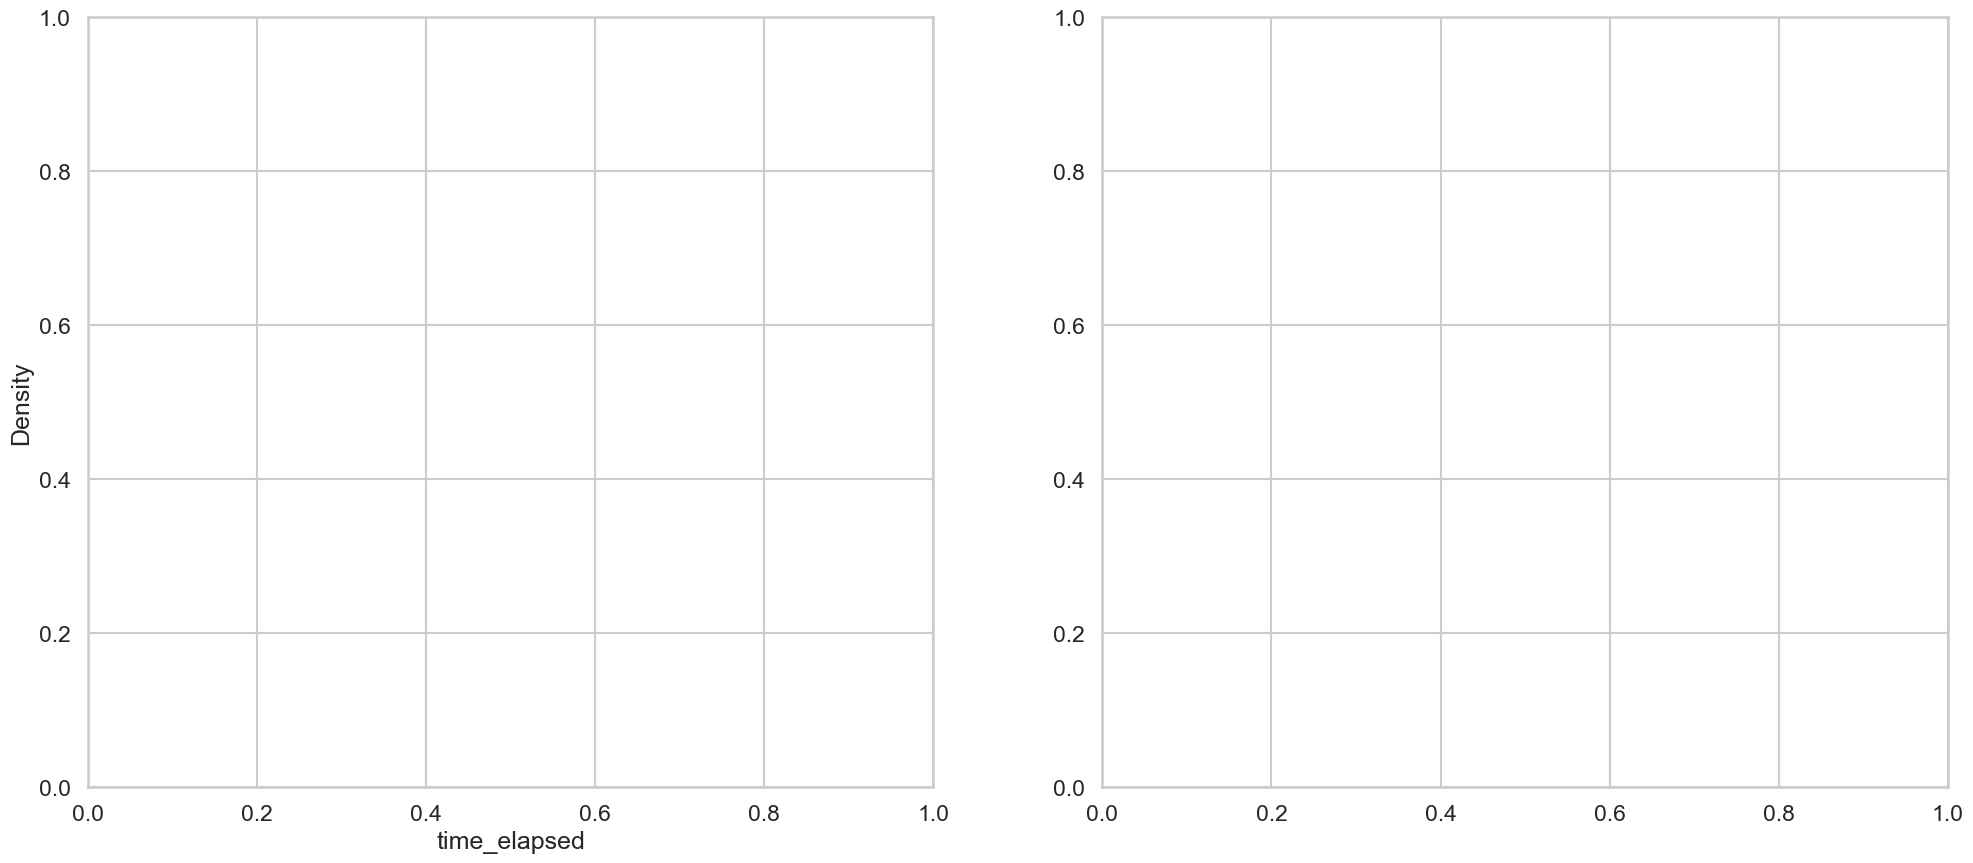

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns

# Filter to only warm-started entries
df_ws = results.copy()  # [results['warm_start'] == True]

df_ws = df_ws[((df_ws['qaoa_variant'] == 'multiangle') & (df_ws['depth'] == 1)) |
              ((df_ws['qaoa_variant'] == 'vanilla') & (df_ws['depth'] == 4))]

# Cleaned labels
graph_label_map = {
    '>>graph6<<Emz_': 'Graph 6',
    '>>graph6<<HmzffJz': 'Graph 9 (Dense)',
    '>>graph6<<Hh_iS_u': 'Graph 9 (Sparse)',
    '>>graph6<<KmzffJznl{hU': 'Graph 12',
}
df_ws['graph_label'] = df_ws['graph_name'].map(graph_label_map)

label_map = {
    'False0': 'Equal Superposition',
    'True0': 'WS HD: 0',
    'True1': 'WS HD: 1',
    'True3': 'WS HD: 3',
    'True5': 'WS HD: 5',
}
df_ws['Qubit Initialization'] = df_ws['warm_start'].astype(str) + df_ws['hamming_dist'].astype(str)
df_ws['Qubit Initialization'] = df_ws['Qubit Initialization'].map(label_map)

# Group by hamming distance to compute percentage of infeasible runs
infeasible_pct = (
    df_ws.groupby('Qubit Initialization')['infeasible']
    .mean()
    .reset_index(name='perc_infeasible')
)
infeasible_pct['perc_infeasible'] *= 100

# Compute percent improvement from the warm-started string.
# 100 * (quantum_obj_value - ws_value) / quantum_obj_value.
df_ws = df_ws[df_ws['quantum_obj_value'] != 0].copy()
df_ws['ws_value'] = df_ws['ws_value'].astype(float)  # ensure numeric
df_ws['perc_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    100 * (df_ws['ws_value'] - df_ws['quantum_obj_value']) / df_ws['ws_value'],
    np.nan
)
df_ws['actual_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    df_ws['ws_value'] - df_ws['quantum_obj_value'],
    np.nan
)

# Create a 2x1 figure (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# 1) Runtime (time_elapsed) by hamming distance
sns.kdeplot(data=df_ws, x='time_elapsed', ax=axes[0], hue='Qubit Initialization', palette='viridis', linewidth=3,legend='full')
axes[0].set_title('Runtime by Qubit Initialization', fontsize=28)
axes[0].set_ylabel('Density', fontsize=26)
axes[0].set_xlabel('Time Elapsed (s)', fontsize=26)
axes[0].set_xlim(left=0)
axes[0].tick_params(axis='both', labelsize=22)
leg = axes[0].get_legend()                     # legend Seaborn already created
leg.set_title("Qubit Initialization", prop={"size": 24})
for txt in leg.get_texts():
    txt.set_fontsize(22)
df_ws['ws_ratio'] = df_ws['ws_value']/df_ws['classic_value']

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")
sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='ratio',
    ax=axes[1],
    marker='o',
    markersize=12,
    linewidth=3,
    color='C0',
    errorbar=None,
    hue='graph_label'
)
axes[1].set_title('Average Ratio by Qubit Initialization', fontsize=28)
axes[1].set_ylabel('Ratio', fontsize=26)
axes[1].set_xlabel('Qubit Initialization', fontsize=26)
axes[1].tick_params(axis='both', labelsize=22)
axes[1].legend(title='Graph Type', title_fontsize=24, fontsize=22)

plt.tight_layout()
plt.savefig('ws_stats.pdf', bbox_inches='tight')
plt.show()

# Create one plot with two subplots side by side for multiangle and vanilla QAOA variants
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.set_style("whitegrid")

for ax, qaoa_type in zip(axarr, ['multiangle', 'vanilla']):
    # Filter data for the current QAOA variant and warm-started solutions with hamming distance > 0
    current_df = df_ws[df_ws['qaoa_variant'] == qaoa_type].copy()
    ws_true = current_df[(current_df['warm_start'] == True) & (current_df['hamming_dist'] > 0)].copy()
    ws_true = ws_true.sort_values('graph_name')
    
    # Create a scatterplot on the current axis
    sns.scatterplot(
        data=ws_true,
        x='ws_value',
        y='quantum_obj_value',
        hue='graph_label',
        style='Qubit Initialization',
        s=100,
        ax=ax
    )
    
    # Draw a diagonal line (y = x) to show the line of no improvement
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'r--', label='No Improvement Line')
    
    ax.set_title(f'{qaoa_type.capitalize()} QAOA: Warm Start Value vs Quantum Solution Value', fontsize=20)
    ax.set_xlabel('Warm Start Value', fontsize=16)
    ax.set_ylabel('Quantum Solution Value', fontsize=16)
    ax.legend(title='Graph Label', fontsize=12)
    
plt.tight_layout()
plt.savefig('warm_start_scatter_side_by_side.pdf', bbox_inches='tight')
plt.show()

# Add a diagonal line (y=x) to show where quantum solution = warm start
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, 'r--', label='No Improvement Line')

# Customize plot
plt.title('Warm Start Value vs Quantum Solution Quality', fontsize=15)
plt.xlabel('Warm Start Solution Value', fontsize=16)
plt.ylabel('Quantum Solution Value', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Graph Type', title_fontsize=16)



plt.tight_layout()
plt.savefig('warm_start_performance.pdf', bbox_inches='tight')
plt.show()
df_ws


# Re-plot average ratio with ws_value overlaid as dotted lines
plt.figure(figsize=(10, 6))

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")
ax = sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='ws_ratio',
    marker='o',
    markersize=12,
    linewidth=3,
    color='C0',
    errorbar=None,
    hue='graph_label'
)
ax.set_title('WS String Ratio by Qubit Initialization', fontsize=28)
ax.set_ylabel('WS String Ratio', fontsize=26)
ax.set_xlabel('Qubit Initialization', fontsize=26)
ax.tick_params(axis='both', labelsize=22)
ax.legend(title='Graph Type', title_fontsize=24, fontsize=22)
plt.tight_layout()
plt.savefig('ws_string_ratio.pdf', bbox_inches='tight')
plt.show()

# Re-plot average ratio with ws_value overlaid as dotted lines
plt.figure(figsize=(10, 6))

# 2) Ratio distribution by hamming distance — upgraded
sns.set(style="whitegrid", context="talk")
ax = sns.lineplot(
    data=df_ws,
    x='Qubit Initialization',
    y='percent_measure_optimal',
    marker='o',
    markersize=12,
    linewidth=3,
    color='C0',
    errorbar=None,
    hue='graph_label'
)
ax.set_title('Probability of measuring Optimal by Qubit Initialization', fontsize=28)
ax.set_ylabel('Probability', fontsize=26)
ax.set_xlabel('Qubit Initialization', fontsize=26)
ax.tick_params(axis='both', labelsize=22)
ax.legend(title='Graph Type', title_fontsize=24, fontsize=22)
plt.tight_layout()
plt.savefig('perc_measure_optimal_HD.pdf', bbox_inches='tight')
plt.show()

print("Lagrangian multipliers used:", df_ws['lagrangian_multiplier'].unique())

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2950228351.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  improvement_stats = pd.concat([improvement_stats, new_row], ignore_index=True)
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2950228351.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2950228351.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')


<Figure size 1600x800 with 0 Axes>

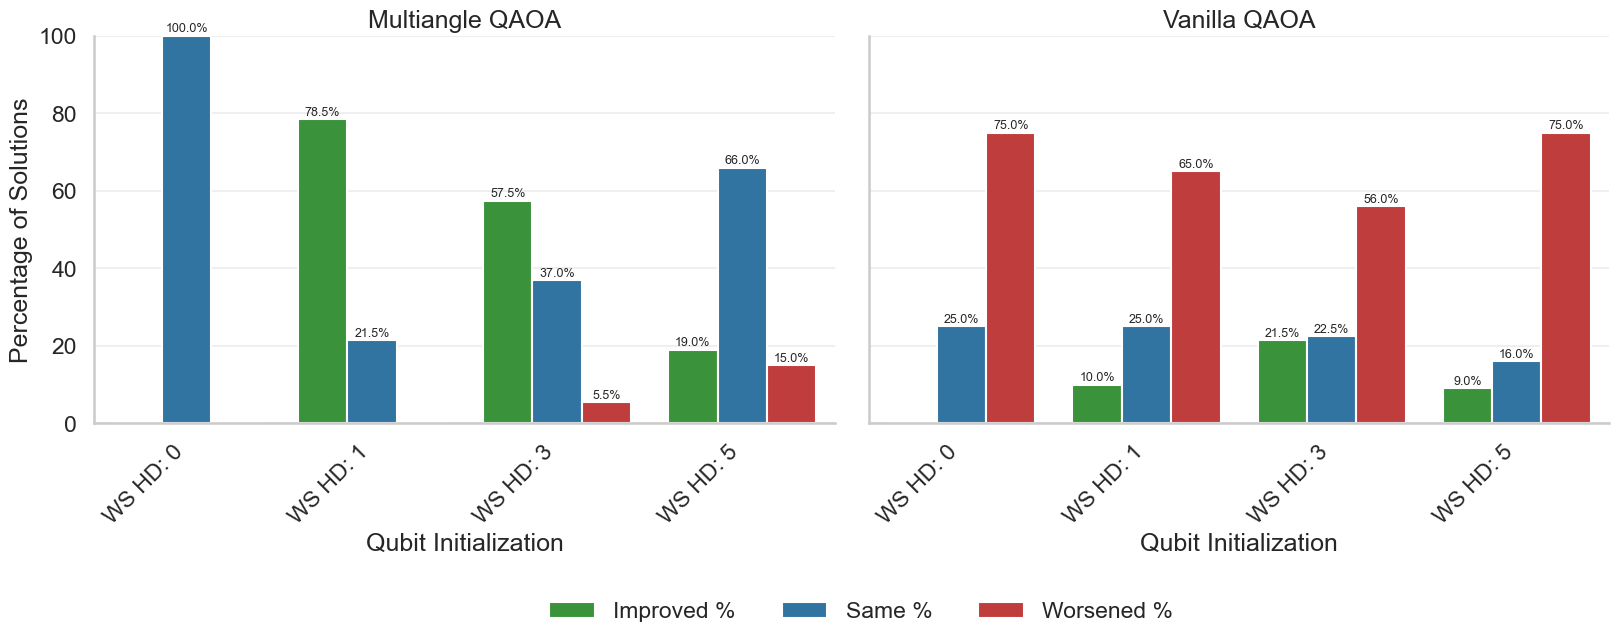

,qaoa_variant,Qubit Initialization,Improved %,Same %,Worsened %,Count
0,multiangle,Equal Superposition,0.0,0.0,0.0,200
1,multiangle,WS HD: 0,0.0,100.0,0.0,200
2,multiangle,WS HD: 1,78.5,21.5,0.0,200
3,multiangle,WS HD: 3,57.5,37.0,5.5,200
4,multiangle,WS HD: 5,19.0,66.0,15.0,200
5,vanilla,Equal Superposition,0.0,0.0,0.0,200
6,vanilla,WS HD: 0,0.0,25.0,75.0,200
7,vanilla,WS HD: 1,10.0,25.0,65.0,200
8,vanilla,WS HD: 3,21.5,22.5,56.0,200
9,vanilla,WS HD: 5,9.0,16.0,75.0,200


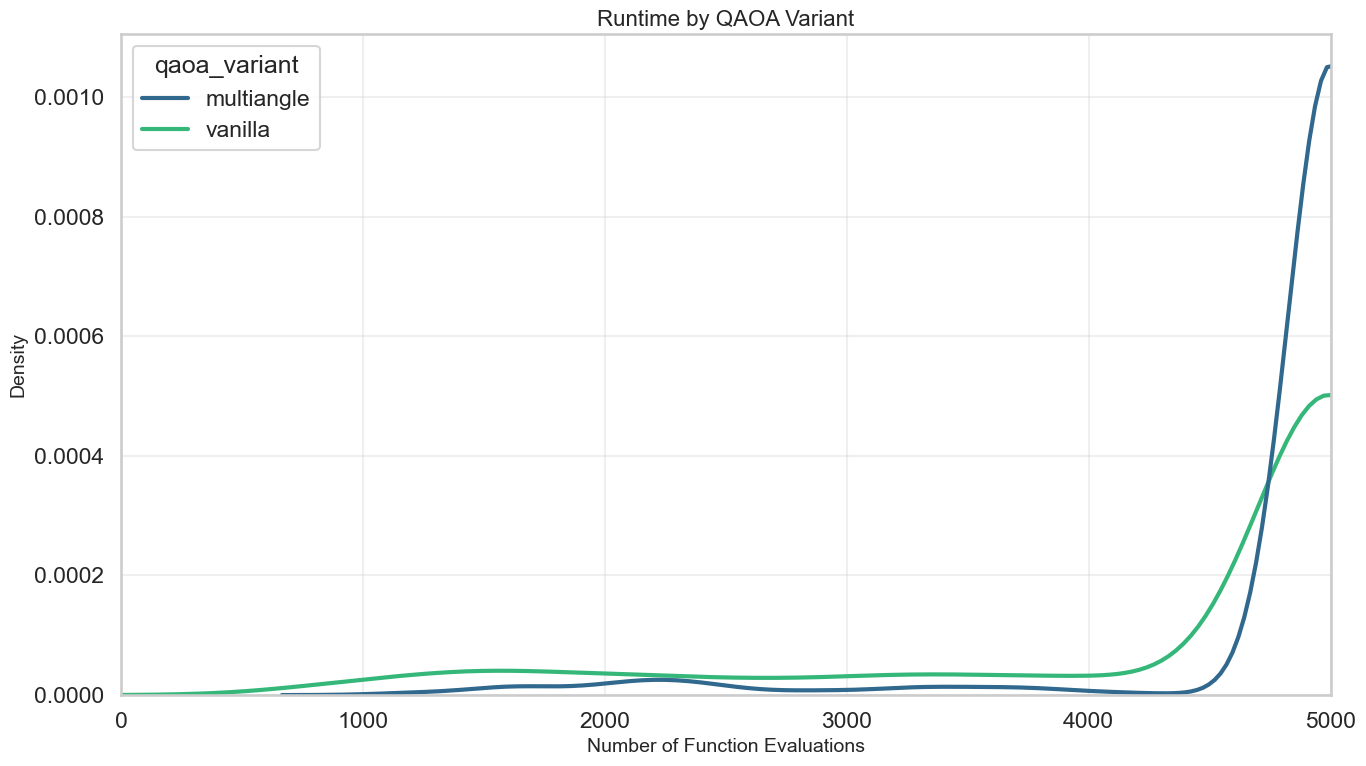

In [ ]:
df_ws = results.copy()
df_ws['actual_improvement'] = np.where(
    df_ws['ws_value'].notnull(),
    df_ws['ws_value'] - df_ws['quantum_obj_value'],
    np.nan
)
df_ws = df_ws[((df_ws['qaoa_variant'] == 'multiangle') & (df_ws['depth'] == 1)) |
              ((df_ws['qaoa_variant'] == 'vanilla') & (df_ws['depth'] == 4))]

# Cleaned labels
graph_label_map = {
    '>>graph6<<Emz_': 'Graph 6',
    '>>graph6<<HmzffJz': 'Graph 9 (Dense)',
    '>>graph6<<Hh_iS_u': 'Graph 9 (Sparse)',
    '>>graph6<<KmzffJznl{hU': 'Graph 12',
}
df_ws['graph_label'] = df_ws['graph_name'].map(graph_label_map)

label_map = {
    'False0': 'Equal Superposition',
    'True0': 'WS HD: 0',
    'True1': 'WS HD: 1',
    'True3': 'WS HD: 3',
    'True5': 'WS HD: 5',
}
df_ws['Qubit Initialization'] = df_ws['warm_start'].astype(str) + df_ws['hamming_dist'].astype(str)
df_ws['Qubit Initialization'] = df_ws['Qubit Initialization'].map(label_map)
# Create a new dataframe to analyze improvement statistics
improvement_stats = pd.DataFrame(columns=['qaoa_variant', 'Qubit Initialization', 'Improved %', 'Same %', 'Worsened %', 'Count'])

# Include all warm started data including hamming distance 0
ws_all = df_ws.copy()

# Filter out Equal Superposition for the visualization
ws_all_filtered = ws_all[ws_all['Qubit Initialization'] != 'Equal Superposition']

# Create a figure for both variants together
plt.figure(figsize=(16, 8))

# For each initialization type and QAOA variant, compute improvement statistics
for qaoa_var in ['multiangle', 'vanilla']:
    ws_filtered = ws_all[ws_all['qaoa_variant'] == qaoa_var]
    
    for init_type in ws_filtered['Qubit Initialization'].unique():
        subset = ws_filtered[ws_filtered['Qubit Initialization'] == init_type]
        total = len(subset)
        
        if total > 0:  # Only process if we have data for this combination
            # Calculate percentages
            improved = (subset['actual_improvement'] > 0.0001).sum() / total * 100
            same = (abs(subset['actual_improvement']) <= 0.0001).sum() / total * 100 
            worsened = (subset['actual_improvement'] < -0.0001).sum() / total * 100
            
            # Add to results dataframe
            new_row = pd.DataFrame({
                'qaoa_variant': [qaoa_var],
                'Qubit Initialization': [init_type],
                'Improved %': [improved],
                'Same %': [same], 
                'Worsened %': [worsened],
                'Count': [total]
            })
            improvement_stats = pd.concat([improvement_stats, new_row], ignore_index=True)

# Sort by initialization type and variant
improvement_stats = improvement_stats.sort_values(['qaoa_variant', 'Qubit Initialization'])

# Create a nice visualization with both variants side by side
# Filter out Equal Superposition for the visualization
improvement_stats_filtered = improvement_stats[improvement_stats['Qubit Initialization'] != 'Equal Superposition']
improvement_stats_melted = pd.melt(
    improvement_stats_filtered, 
    id_vars=['qaoa_variant', 'Qubit Initialization', 'Count'],
    value_vars=['Improved %', 'Same %', 'Worsened %'],
    var_name='Result', value_name='Percentage'
)

# Set up a custom color palette
palette = {'Improved %': '#2ca02c', 'Same %': '#1f77b4', 'Worsened %': '#d62728'}

# Create a grouped bar chart with both variants side by side
ax = sns.catplot(
    x='Qubit Initialization', 
    y='Percentage', 
    hue='Result', 
    col='qaoa_variant',
    data=improvement_stats_melted, 
    kind='bar',
    palette=palette,
    height=6, aspect=1.2
)
# Clean up extra legends

sns.move_legend(ax, 'lower left', bbox_to_anchor= (0.33,-0.1),ncol=3,title=None)
# Set titles and labels
ax.set_axis_labels(None, 'Percentage of Solutions')
ax.set_titles(col_template='{col_name} QAOA')

# Adjust ylim
for ax_i in ax.axes[0]:
    ax_i.set_ylim(0, 100)
    ax_i.grid(axis='y', alpha=0.3)
    # Add percentage values on top of each bar
    for p in ax_i.patches:
        height = p.get_height()
        if height > 0:
            ax_i.text(
                p.get_x() + p.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', 
                fontsize=9
            )
    
    # Clean up x-axis labels
    ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45, ha='right')

# Capitalize first letter of each subplot title
for ax_i, title in zip(ax.axes[0], ['Multiangle', 'Vanilla']):
    ax_i.set_title(f"{title} QAOA")

plt.tight_layout()
plt.savefig('warm_start_improvement_stats_combined.pdf', bbox_inches='tight')
plt.show()

# Display the detailed table
display(improvement_stats.round(2))


# Create a figure and analyze runtime performance
plt.figure(figsize=(14, 8))

# Plot runtime distribution by QAOA variant
sns.kdeplot(data=df_ws, x='quantum_func_evals', hue='qaoa_variant', palette='viridis', linewidth=3)

# Set plot styling
plt.title('Runtime by QAOA Variant', fontsize=16)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Number of Function Evaluations', fontsize=14)
plt.xlim((0,5000))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('runtime_by_qaoa_variant.pdf', bbox_inches='tight')
plt.show()

<Axes: xlabel='ratio', ylabel='ws_value'>

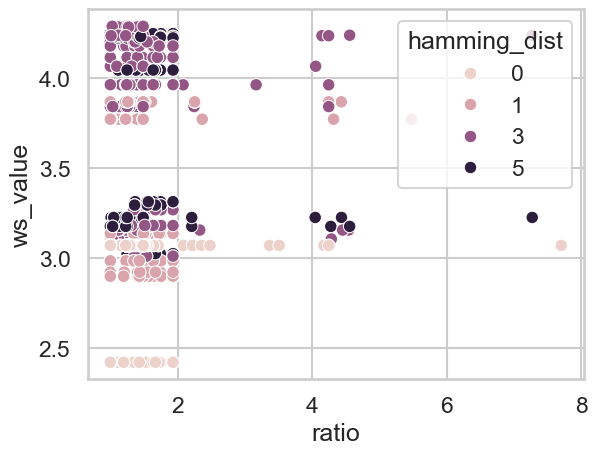

In [ ]:
lag_ws = results_lagrange[results_lagrange['warm_start']==True]
sns.scatterplot(data=lag_ws,x='ratio',y='ws_value',hue='hamming_dist')

Distribution of depth and variants in the dataset:
qaoa_variant  depth  lagrangian_multiplier
multiangle    1      1                        100
                     2                        100
                     4                        100
                     10                       100
vanilla       4      1                         51
                     2                         99
                     4                         96
                     10                        91
dtype: int64


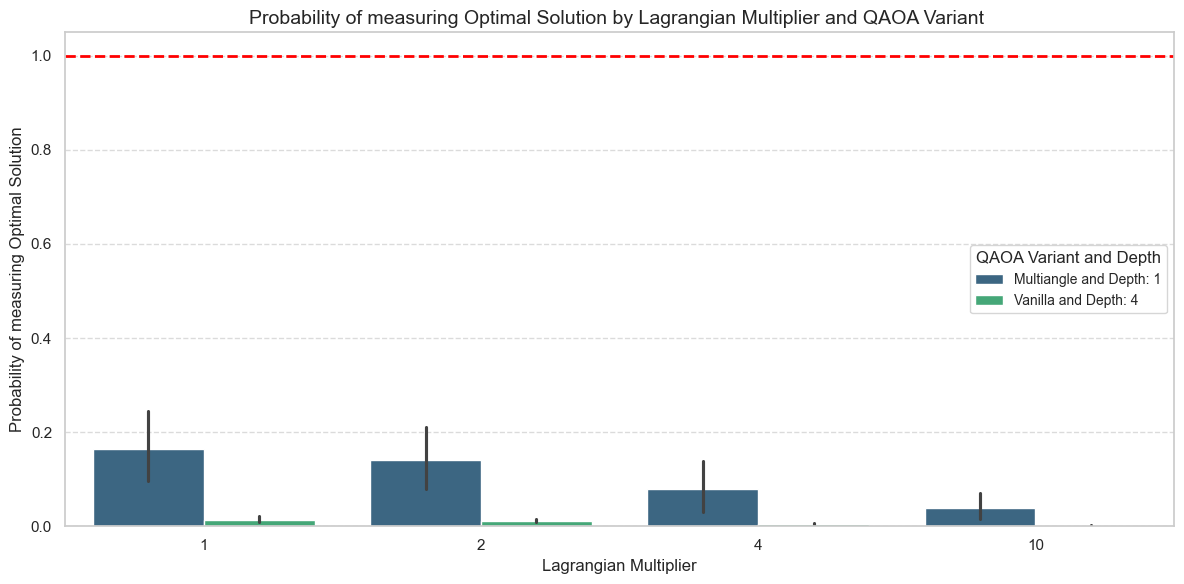

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2544558198.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2544558198.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='QAOA Variant and Depth', fontsize=10)


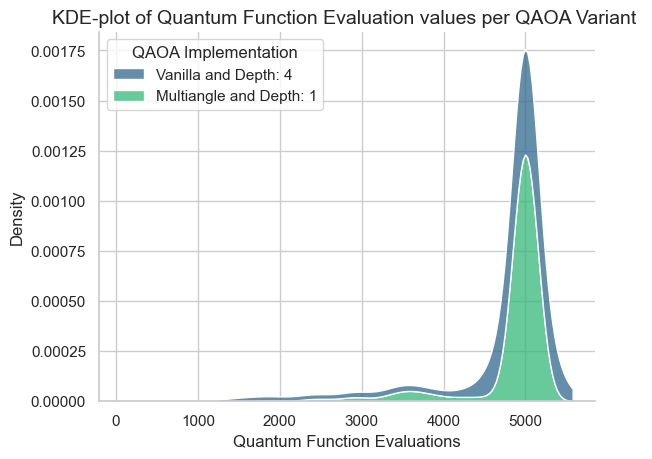

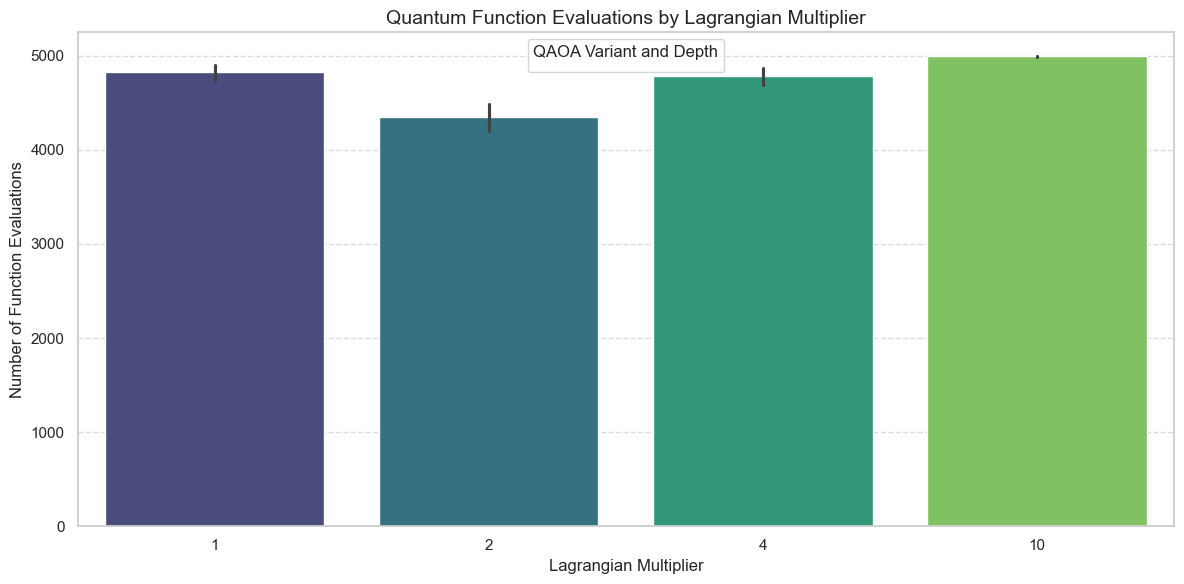

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_13184\2544558198.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


lagrangian_multiplier  hamming_dist  warm_start
1                      0             False         1.329867
                                     True          1.129419
                       1             True          1.150620
                       3             True          1.226369
                       5             True          1.241519
2                      0             False         1.279663
                                     True          1.220686
                       1             True          1.248898
                       3             True          1.358523
                       5             True          1.368150
4                      0             False         1.368708
                                     True          1.353944
                       1             True          1.393329
                       3             True          1.493982
                       5             True          1.455743
10                     0             False         1

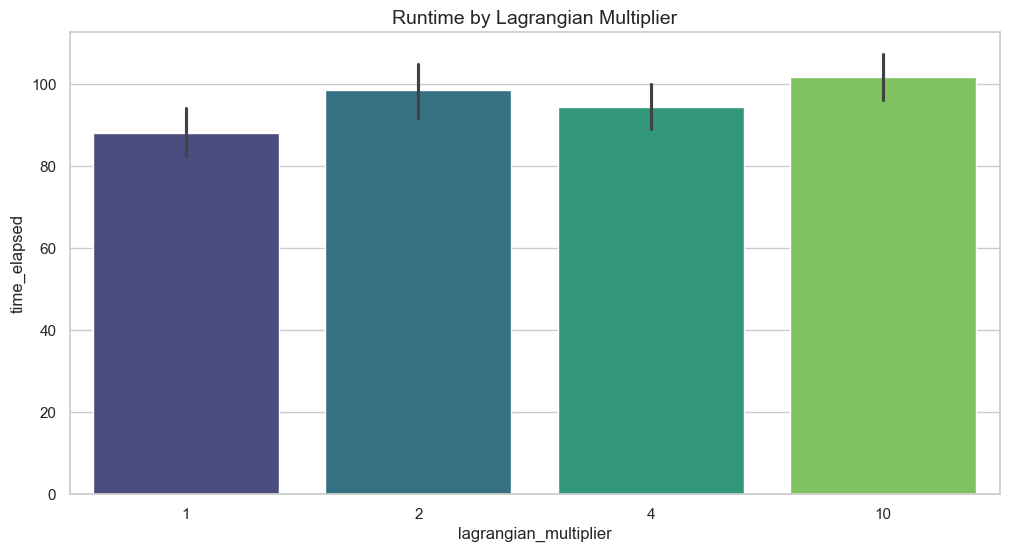

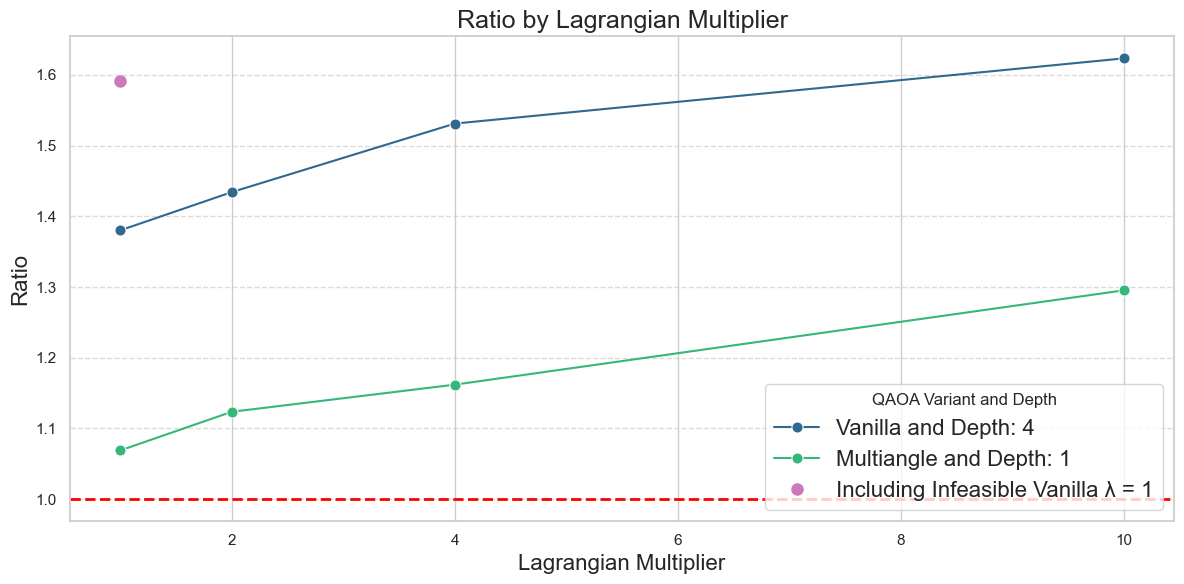

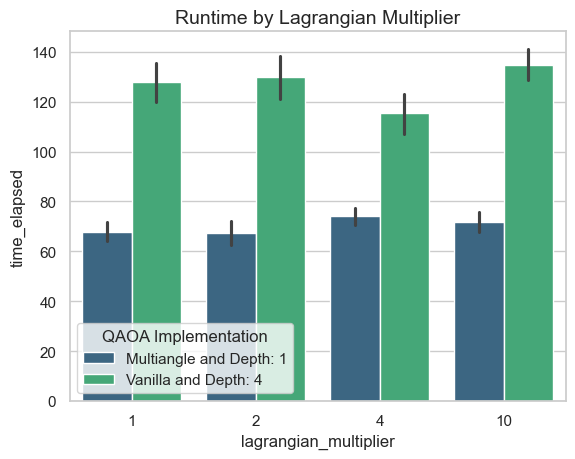

<Figure size 1200x600 with 0 Axes>

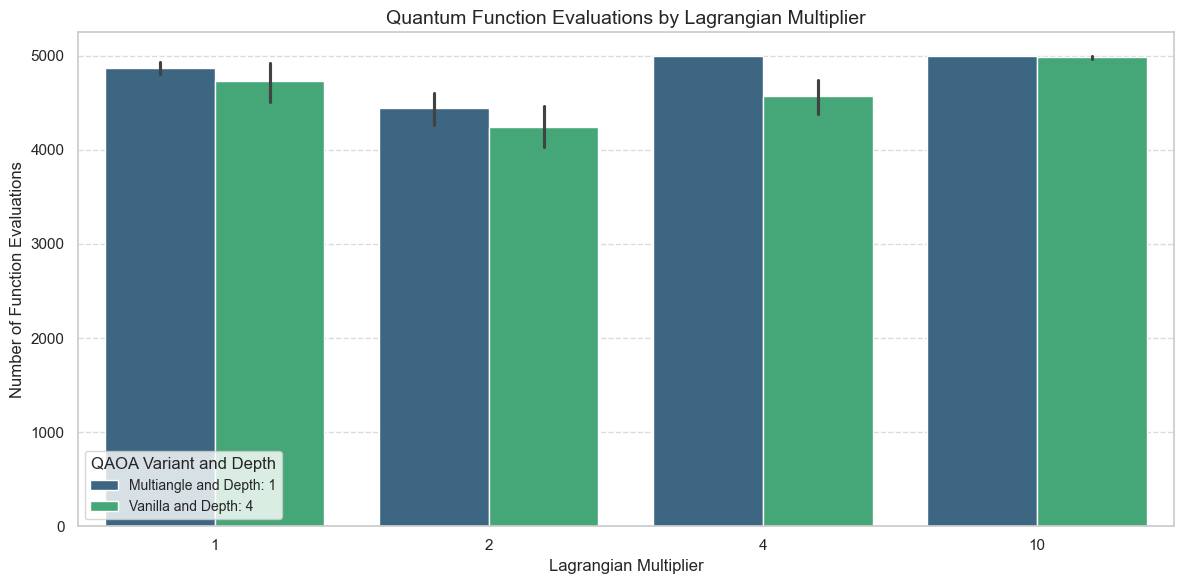

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="colorblind")
# Create a visualization to analyze solution ratio by lagrangian multiplier and qaoa variant
plt.figure(figsize=(12, 6))



# Filter only feasible solutions
feasible_df = results_lagrange[results_lagrange['infeasible'] == False].copy()
feasible_df = feasible_df[feasible_df['warm_start']==False]
#feasible_df = results_lagrange.copy()
# For better analysis, let's group the data by variant, lagrangian multiplier and depth
# This will give us a clearer picture of how these factors affect solution quality



# Focus on a subset with specific depths that provide a good comparison point
# Keep only depth 1 for multiangle and depth 4 for vanilla for fair comparison
subset = feasible_df[
    ((feasible_df['qaoa_variant'] == 'multiangle') & (feasible_df['depth'] == 1)) | 
    ((feasible_df['qaoa_variant'] == 'vanilla') & (feasible_df['depth'] == 4))
]

# Let's analyze what depth & variants are available in our dataset
print("Distribution of depth and variants in the dataset:")
print(subset.groupby(['qaoa_variant', 'depth','lagrangian_multiplier']).size())
# Create a new column that combines variant and depth for better labeling
subset['QAOA Implementation'] = subset.apply(lambda row: f"{row['qaoa_variant'].capitalize()} and Depth: {row['depth']}", axis=1)

# Create the barplot
sns.barplot(data=subset, x='lagrangian_multiplier', y='percent_measure_optimal', hue='QAOA Implementation', palette='viridis')


# Add horizontal line at ratio=1 to indicate optimal solution quality
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Customize the plot
plt.title('Probability of measuring Optimal Solution by Lagrangian Multiplier and QAOA Variant ', fontsize=14)
plt.xlabel('Lagrangian Multiplier', fontsize=12)
plt.ylabel('Probability of measuring Optimal Solution', fontsize=12)
plt.legend(title='QAOA Variant and Depth', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('lagrangian_percentoptimal_depth1_4.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()


sns.kdeplot(data= subset, x = 'quantum_func_evals' , hue='QAOA Implementation', multiple='stack',palette='viridis')
plt.title('KDE-plot of Quantum Function Evaluation values per QAOA Variant ', fontsize=14)
sns.despine()
plt.xlabel('Quantum Function Evaluations', fontsize= 12)
plt.savefig('lagrangian_kdeplot.pdf', bbox_inches='tight')

# Create a figure for quantum function evaluations by Lagrangian multiplier
plt.figure(figsize=(12, 6))

# Create the boxplot to show distribution
sns.barplot(
    data=feasible_df, 
    x='lagrangian_multiplier', 
    y='quantum_func_evals',
    palette='viridis'
)

# Customize the plot
plt.title('Quantum Function Evaluations by Lagrangian Multiplier', fontsize=14)
plt.xlabel('Lagrangian Multiplier', fontsize=12)
plt.ylabel('Number of Function Evaluations', fontsize=12)
plt.legend(title='QAOA Variant and Depth', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('lagrangian_func_evals.pdf', bbox_inches='tight')
plt.show()

#
plt.figure(figsize=(12, 6))


sns.barplot(
    data=feasible_df,
    x='lagrangian_multiplier',
    y='time_elapsed',
    palette='viridis'
)


plt.title('Runtime by Lagrangian Multiplier', fontsize=14)# Customize the plotntation',tiplier',    data=subset, sns.barplot( Create a figure for runtime by Lagrangian multiplier# Create a figure for quantum function evaluations by Lagrangian multiplier
plt.figure(figsize=(12, 6))
print(results_lagrange.groupby(['lagrangian_multiplier','hamming_dist','warm_start'])['ratio'].mean())
# Create the boxplot to show distribution
sns.lineplot(
    data=subset, 
    x='lagrangian_multiplier', 
    y='ratio',
    hue='QAOA Implementation',
    palette='viridis',
    errorbar=None,
    marker='o',
    markersize=8,
)
red_dot = results_lagrange[(results_lagrange['lagrangian_multiplier'] == 1) & (results_lagrange['depth']==4) & (results_lagrange['warm_start']==False)]['ratio'].mean()
print('red dot', red_dot)
# Customize the plot
plt.title('Ratio by Lagrangian Multiplier', fontsize=18)
plt.xlabel('Lagrangian Multiplier', fontsize=16)
plt.ylabel('Ratio', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add a reference point to show mean ratio for depth=1 multiangle QAOA
plt.plot(1, red_dot, 'mo', markersize=8, label='Including Infeasible Vanilla λ = 1')

plt.legend(title='QAOA Variant and Depth', fontsize=16,loc='lower right')

# Add horizontal line at ratio=1 to indicate optimal solution quality
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.savefig('lagrangian_ratio.pdf', bbox_inches='tight')
plt.show()

#
plt.title('Runtime by Lagrangian Multiplier', fontsize=14)
# Customize the plot

sns.barplot(
    palette='viridis',
    hue='QAOA Implementation',
    y='time_elapsed',
    x='lagrangian_multiplier', 
    data=subset, )


plt.figure(figsize=(12, 6)) # Create a figure for quantum function evaluations by Lagrangian multiplier
plt.figure(figsize=(12, 6))

# Create the boxplot to show distribution
sns.barplot(
    data=subset, 
    x='lagrangian_multiplier', 
    y='quantum_func_evals',
    hue='QAOA Implementation',
    palette='viridis'
)

# Customize the plot
plt.title('Quantum Function Evaluations by Lagrangian Multiplier', fontsize=14)
plt.xlabel('Lagrangian Multiplier', fontsize=12)
plt.ylabel('Number of Function Evaluations', fontsize=12)
plt.legend(title='QAOA Variant and Depth', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('lagrangian_func_evals.pdf', bbox_inches='tight')
plt.show()

# Create a figure for runtime by Lagrangian multiplier

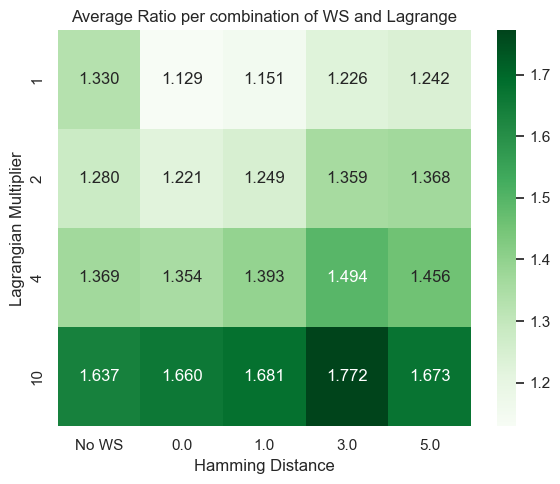

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group and aggregate the ratio
df = results_lagrange.groupby(['lagrangian_multiplier', 'hamming_dist', 'warm_start'])['ratio'].mean().reset_index()

df.loc[df['warm_start']==False, ['hamming_dist']] = None



# Pivot tables for warm_start = True and False
pivot_true = df.pivot(
    index='lagrangian_multiplier', columns='hamming_dist', values='ratio'
)


plt.figure(figsize=(6, 5))
ax = sns.heatmap(pivot_true, annot=True, fmt=".3f", cmap="Greens")  # <-- Capture the axis as 'ax'

ax.set_title("Average Ratio per combination of WS and Lagrange")
ax.set_xlabel("Hamming Distance")
ax.set_ylabel("Lagrangian Multiplier")

# Fix NaN tick labels on x-axis
xticklabels = ax.get_xticklabels()
new_labels = ['No WS' if str(label.get_text()) == 'nan' else label.get_text() for label in xticklabels]
ax.set_xticklabels(new_labels)

plt.tight_layout()
plt.savefig('heatmap.pdf',bbox_inches='tight')
plt.show()

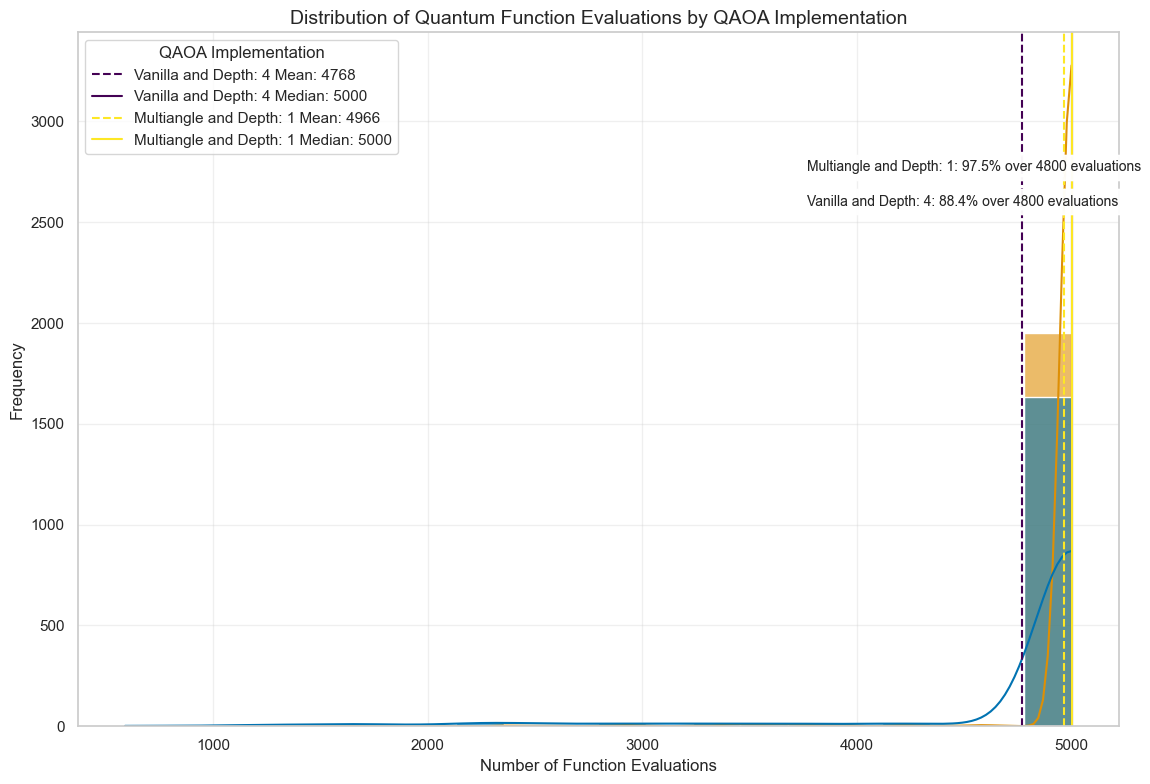

In [ ]:
import seaborn as sns

# Create a visualization of the distribution of quantum function evaluations
import matplotlib.pyplot as plt

# Get the distribution per QAOA Implementation
plt.figure(figsize=(12, 8))

# Use a kernel density estimate plot to show the distribution
sns.histplot(
    data=subset, 
    x='quantum_func_evals',
    hue='QAOA Implementation',
    bins=20,
    kde=True,
    alpha=0.6
)

# Add vertical lines for the means of each group
for impl, color in zip(subset['QAOA Implementation'].unique(), plt.cm.viridis(np.linspace(0, 1, len(subset['QAOA Implementation'].unique())))):
    mean_evals = subset[subset['QAOA Implementation'] == impl]['quantum_func_evals'].mean()
    median_evals = subset[subset['QAOA Implementation'] == impl]['quantum_func_evals'].median()
    plt.axvline(x=mean_evals, color=color, linestyle='--', 
                label=f'{impl} Mean: {mean_evals:.0f}')
    plt.axvline(x=median_evals, color=color, linestyle='-', 
                label=f'{impl} Median: {median_evals:.0f}')
                # Calculate and display statistics for each implementation
    for impl in sorted(subset['QAOA Implementation'].unique()):
        eval_data = subset[subset['QAOA Implementation'] == impl]['quantum_func_evals']
        pct_high = (eval_data > 4999).mean() * 100
        plt.text(0.7, 0.8 - sorted(subset['QAOA Implementation'].unique()).index(impl) * 0.05, 
                    f"{impl}: {pct_high:.1f}% over 4800 evaluations",
                    transform=plt.gca().transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))
# Customize the plot
plt.title('Distribution of Quantum Function Evaluations by QAOA Implementation', fontsize=14)
plt.xlabel('Number of Function Evaluations', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='QAOA Implementation')

plt.tight_layout()
plt.savefig('func_evals_distribution.pdf', bbox_inches='tight')
plt.show()


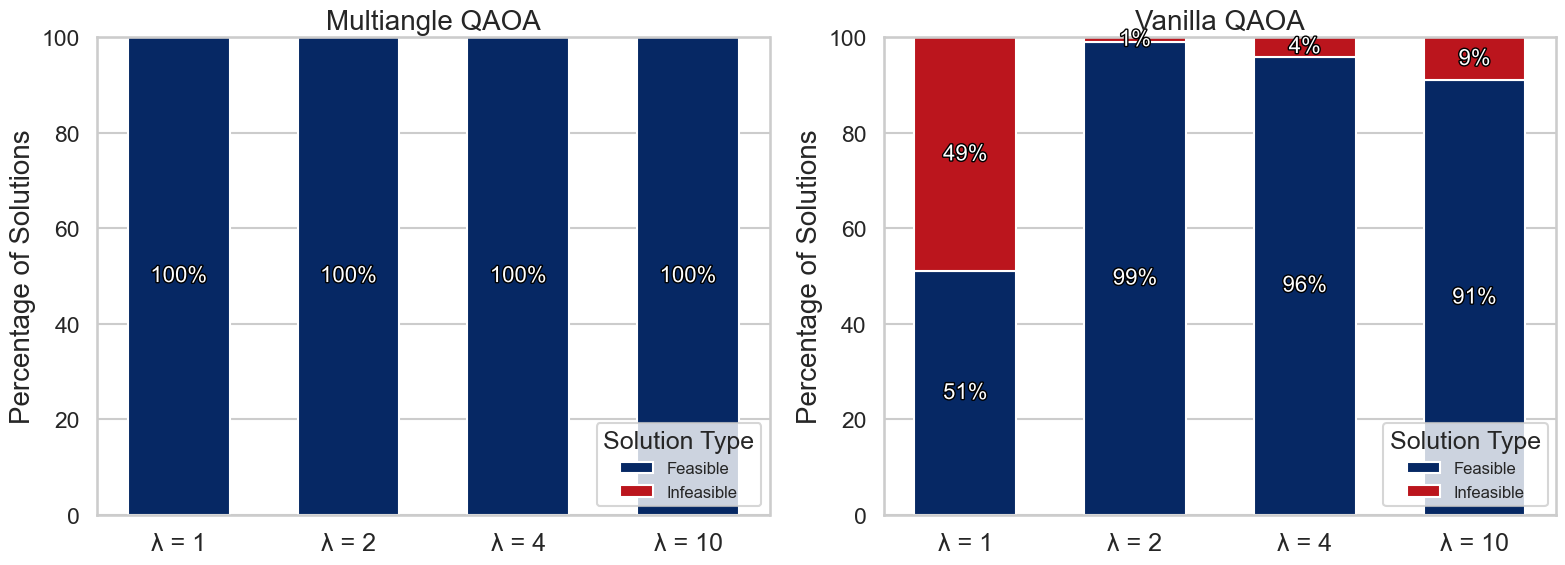

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patheffects as path_effects

# --- Data prep ---
df_analysis = results_lagrange.copy()
df_analysis = df_analysis[df_analysis['warm_start']==False]

# Group by config and count
grouped = df_analysis.groupby(['qaoa_variant', 'lagrangian_multiplier', 'infeasible']).size().reset_index(name='count')

# Create two separate dataframes for multiangle and vanilla
grouped_multiangle = grouped[grouped['qaoa_variant'] == 'multiangle']
grouped_vanilla = grouped[grouped['qaoa_variant'] == 'vanilla']

# Process each variant separately
def process_variant_data(data):
    # Pivot to wide format
    pivot_df = data.pivot_table(
        index=['lagrangian_multiplier'],
        columns='infeasible',
        values='count',
        fill_value=0
    ).reset_index()
    
    # Rename for clarity    
    pivot_df.rename(columns={False: 'feasible', True: 'infeasible'}, inplace=True)
    
    # Calculate percentages
    pivot_df['total'] = pivot_df['feasible'] + pivot_df['infeasible']
    pivot_df['feasible_pct'] = pivot_df['feasible'] / pivot_df['total'] * 100
    pivot_df['infeasible_pct'] = pivot_df['infeasible'] / pivot_df['total'] * 100
    
    return pivot_df

# Handle the case where one variant might not have any infeasible results
if 'True' not in grouped_multiangle['infeasible'].values:
    # Add a placeholder row with infeasible=True if none exists
    placeholder_row = grouped_multiangle.iloc[0].copy()
    placeholder_row['infeasible'] = True
    placeholder_row['count'] = 0
    grouped_multiangle = pd.concat([grouped_multiangle, pd.DataFrame([placeholder_row])])

pivot_multiangle = process_variant_data(grouped_multiangle)
pivot_vanilla = process_variant_data(grouped_vanilla)

# --- Create a figure with two subplots side by side ---
sns.set_theme(style="whitegrid", context="talk")
colors = {'Feasible': "#062864", 'Infeasible': "#BB151D"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper function to plot a single variant
def plot_variant(pivot_df, ax, title):
    x = np.arange(len(pivot_df))
    width = 0.6
    
    # Plot feasible bar base
    bars1 = ax.bar(x, pivot_df['feasible_pct'], width, label='Feasible', color=colors['Feasible'])
    
    # Plot infeasible on top
    bars2 = ax.bar(x, pivot_df['infeasible_pct'], width, bottom=pivot_df['feasible_pct'], 
                   label='Infeasible', color=colors['Infeasible'])
    
    # Add percentage labels
    for i, row in pivot_df.iterrows():
        if row['feasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] / 2, 
                f"{row['feasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        if row['infeasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] + row['infeasible_pct'] / 2, 
                f"{row['infeasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    
    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels([f"λ = {d}" for d in pivot_df['lagrangian_multiplier']], fontsize=18)
    ax.set_ylabel("Percentage of Solutions", fontsize=20)
    ax.set_ylim(0, 100)
    ax.set_title(title, fontsize=20)
    
    # Add legend
    ax.legend(title="Solution Type", fontsize=12, title_fontsize=18, loc='lower right')

# Plot each variant on its respective axis
plot_variant(pivot_multiangle, ax1, "Multiangle QAOA")
plot_variant(pivot_vanilla, ax2, "Vanilla QAOA")

plt.tight_layout()
plt.savefig('lagrangian_feasible_percent.pdf', bbox_inches='tight')
plt.show()


In [ ]:
results['improvement'] = results['quantum_obj_value'] - results['hamming_obj_func']
#results[results['ws_value'] < results['quantum_obj_value']][['quantum_obj_value', 'ws_value']]
#print(results[results['ws_value'] < results['quantum_obj_value']][['quantum_obj_value', 'ws_value']])
print("Improvement column info:")
print(results['improvement'].describe())

Improvement column info:
count    6400.000000
mean        0.084759
std         0.978942
min        -2.200612
25%        -0.475322
50%         0.000000
75%         0.392658
max        14.533198
Name: improvement, dtype: float64


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\2538897838.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\2538897838.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[1].get_xticklabels()])


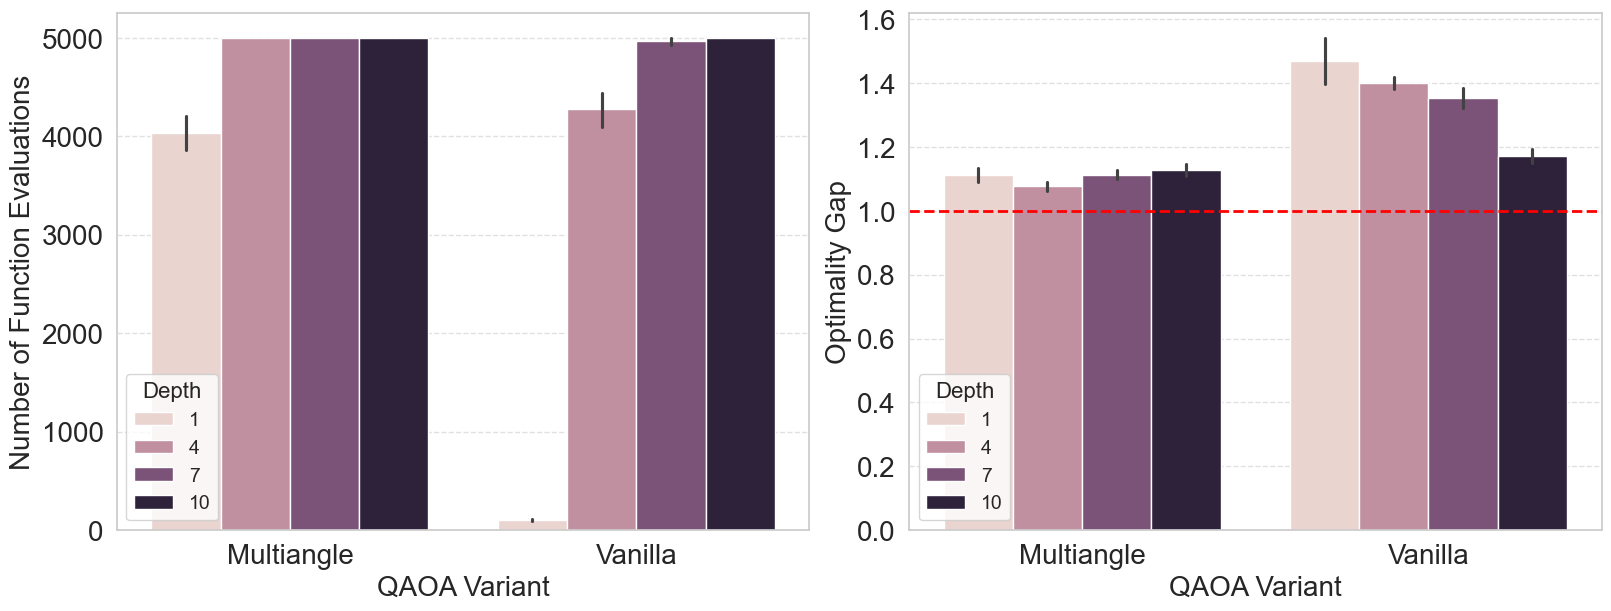

Summary Statistics by QAOA Variant and Depth:
                   quantum_func_evals                                ratio  \
                                 mean      std     min     max count  mean   
qaoa_variant depth                                                           
multiangle   1                4032.26  1286.70  1187.0  5000.0   200  1.11   
             4                5000.00     0.00  5000.0  5000.0   200  1.08   
             7                5000.00     0.00  5000.0  5000.0   200  1.11   
             10               5000.00     0.00  5000.0  5000.0   200  1.13   
vanilla      1                 102.05    57.55    63.0   338.0    88  1.47   
             4                4272.60  1225.34  1204.0  5000.0   189  1.40   
             7                4966.56   236.10  2349.0  5000.0   181  1.35   
             10               5000.00     0.00  5000.0  5000.0   200  1.17   

                                     
                     std  min   max  
qaoa_variant depth 

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
df = results.copy()


df = df[df['warm_start'] == False]
df = df[df['infeasible'] == False]
df = df[df['backend_mode'] =='statevector']
df['depth'] = df['depth'].astype(int)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# First subplot - Quantum Function Evaluations
sns.barplot(data=df, x="qaoa_variant", y="quantum_func_evals", hue="depth", ax=axes[0])
axes[0].set_xlabel("QAOA Variant", fontsize=20)
axes[0].set_ylabel("Number of Function Evaluations", fontsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].legend(title="Depth", title_fontsize=16, fontsize=14)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[0].get_xticklabels()])

# Second subplot - Solution Quality
sns.barplot(data=df, x="qaoa_variant", y="ratio", hue="depth", ax=axes[1])
axes[1].set_xlabel("QAOA Variant", fontsize=20)
axes[1].set_ylabel("Optimality Gap", fontsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].legend(title="Depth", title_fontsize=16, fontsize=14)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
axes[1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[1].get_xticklabels()])

# Add a horizontal red line at y=1 for the ratio plot to indicate optimal solution
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2)

plt.savefig('CS_metrics.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Table showing summary statistics for quantum function evaluations by QAOA variant and depth
summary_stats = df.groupby(['qaoa_variant', 'depth'])[['quantum_func_evals', 'ratio']].agg({
    'quantum_func_evals': ['mean', 'std', 'min', 'max', 'count'],
    'ratio': ['mean', 'std', 'min', 'max']
})

# Format the table for better readability
summary_stats = summary_stats.round(2)
print("Summary Statistics by QAOA Variant and Depth:")
print(summary_stats)

# Calculate overall average and standard deviation for each variant regardless of depth
overall_stats = df.groupby(['qaoa_variant'])[['quantum_func_evals', 'ratio']].agg({
    'quantum_func_evals': ['mean', 'std'],
    'ratio': ['mean', 'std']
}).round(2)

print("\nOverall Statistics by QAOA Variant:")
print(overall_stats)

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1920018668.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], fontsize=14)


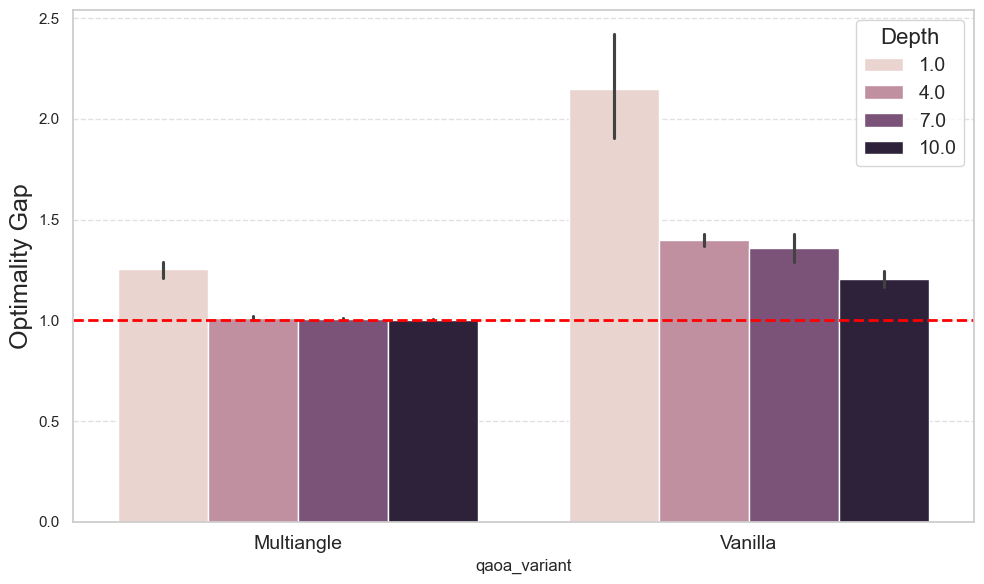

In [81]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Filter only graph size 6 data
df_size_6 = results[results['graph_size'] == 6].copy()
df_size_6 = df_size_6[df_size_6['warm_start']==False]
#df_size_6 = df_size_6[df_size_6['infeasible']==False]
# Create figure
plt.figure(figsize=(10, 6))

# Set theme
sns.set_theme(style="whitegrid", palette="colorblind")

# Plot data
sns.barplot(data=df_size_6, x="qaoa_variant", y="ratio", hue="depth")

# Add horizontal line at ratio=1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Customize plot
plt.ylabel("Optimality Gap", fontsize=18)
plt.legend(title="Depth", title_fontsize=16, fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
ax = plt.gca()
ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], fontsize=14)



plt.tight_layout()
plt.savefig('CS_infeasible_smallgraph.pdf',bbox_inches='tight')

plt.show()

graph_name              backend_mode    infeasible
>>graph6<<Emz_          noisy_sampling  False          532
                                        True            69
                        statevector     False         1939
                                        True            61
>>graph6<<Hh_iS_u       noisy_sampling  False          562
                                        True            34
                        statevector     False         1976
                                        True            24
>>graph6<<HmzffJz       noisy_sampling  False          394
                                        True           205
                        statevector     False         1756
                                        True           244
>>graph6<<KmzffJznl{hU  noisy_sampling  False          291
                                        True           233
                        statevector     False         1796
                                        True           204
Name:

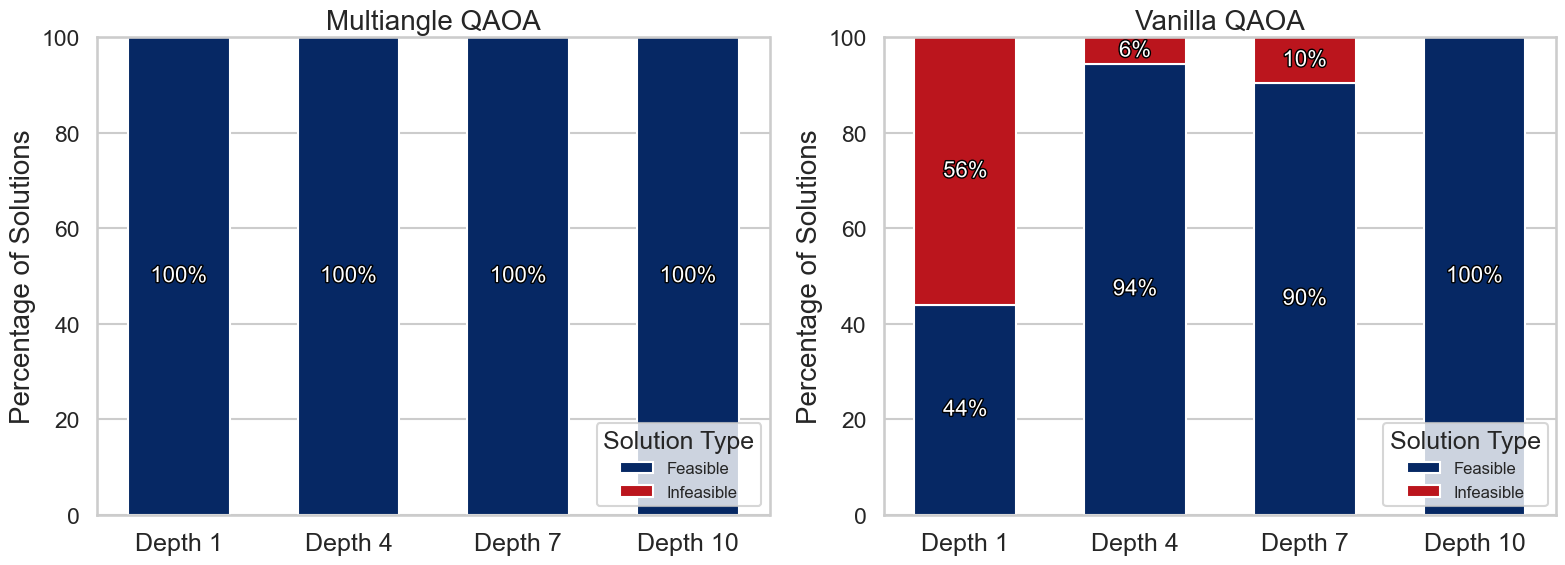

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Data prep ---
df_analysis = results.copy()
print(results.groupby(['graph_name','backend_mode'])['infeasible'].value_counts())
df_analysis = df_analysis[df_analysis['warm_start']==False]
df_analysis = df_analysis[df_analysis['backend_mode']=='statevector']

# Group by config and count
grouped = df_analysis.groupby(['qaoa_variant', 'depth', 'infeasible']).size().reset_index(name='count')

# Create two separate dataframes for multiangle and vanilla
grouped_multiangle = grouped[grouped['qaoa_variant'] == 'multiangle']
grouped_vanilla = grouped[grouped['qaoa_variant'] == 'vanilla']

# Process each variant separately
def process_variant_data(data):
    # Pivot to wide format
    pivot_df = data.pivot_table(
        index=['depth'],
        columns='infeasible',
        values='count',
        fill_value=0
    ).reset_index()
    print("1",pivot_df.columns)
    # Rename for clarity    
    pivot_df.rename(columns={False: 'feasible', True: 'infeasible'}, inplace=True)
    print("2",pivot_df.columns)
    # Calculate percentages
    pivot_df['total'] = pivot_df['feasible'] + pivot_df['infeasible']
    pivot_df['feasible_pct'] = pivot_df['feasible'] / pivot_df['total'] * 100
    pivot_df['infeasible_pct'] = pivot_df['infeasible'] / pivot_df['total'] * 100
    
    return pivot_df

# Handle the case where multiangle might not have any infeasible results
if 'True' not in grouped_multiangle['infeasible'].values:
    # Add a placeholder row with infeasible=True if none exists
    placeholder_row = grouped_multiangle.iloc[0].copy()
    placeholder_row['infeasible'] = True
    placeholder_row['count'] = 0
    grouped_multiangle = pd.concat([grouped_multiangle, pd.DataFrame([placeholder_row])])

pivot_multiangle = process_variant_data(grouped_multiangle)
pivot_vanilla = process_variant_data(grouped_vanilla)
import matplotlib.patheffects as path_effects
# --- Create a figure with two subplots side by side ---
sns.set_theme(style="whitegrid", context="talk")
colors = {'Feasible': "#062864", 'Infeasible': "#BB151D"}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Helper function to plot a single variant
def plot_variant(pivot_df, ax, title):
    x = np.arange(len(pivot_df))
    width = 0.6
    
    # Plot feasible bar base
    bars1 = ax.bar(x, pivot_df['feasible_pct'], width, label='Feasible', color=colors['Feasible'])
    
    # Plot infeasible on top
    bars2 = ax.bar(x, pivot_df['infeasible_pct'], width, bottom=pivot_df['feasible_pct'], 
                   label='Infeasible', color=colors['Infeasible'])
    
    # Add percentage labels
    for i, row in pivot_df.iterrows():
        if row['feasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] / 2, 
                f"{row['feasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        if row['infeasible_pct'] > 0:
            text = ax.text(
                x[i], 
                row['feasible_pct'] + row['infeasible_pct'] / 2, 
                f"{row['infeasible_pct']:.0f}%", 
                ha='center', 
                va='center', 
                fontsize=16, 
                color='white'
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    
    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels([f"Depth {d:.0f}" for d in pivot_df['depth']], fontsize=18)
    ax.set_ylabel("Percentage of Solutions", fontsize=20)
    ax.set_ylim(0, 100)
    ax.set_title(title, fontsize=20)
    
    # Add legend
    ax.legend(title="Solution Type", fontsize=12, title_fontsize=18, loc='lower right')

# Plot each variant on its respective axis
plot_variant(pivot_multiangle, ax1, "Multiangle QAOA")
plot_variant(pivot_vanilla, ax2, "Vanilla QAOA")

plt.tight_layout()
plt.savefig('CS_feasible_percent.pdf', bbox_inches='tight')
plt.show()


C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1651622868.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1651622868.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 1].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1651622868.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1651622868.py:53: UserWarning: set_ticklabels() sh

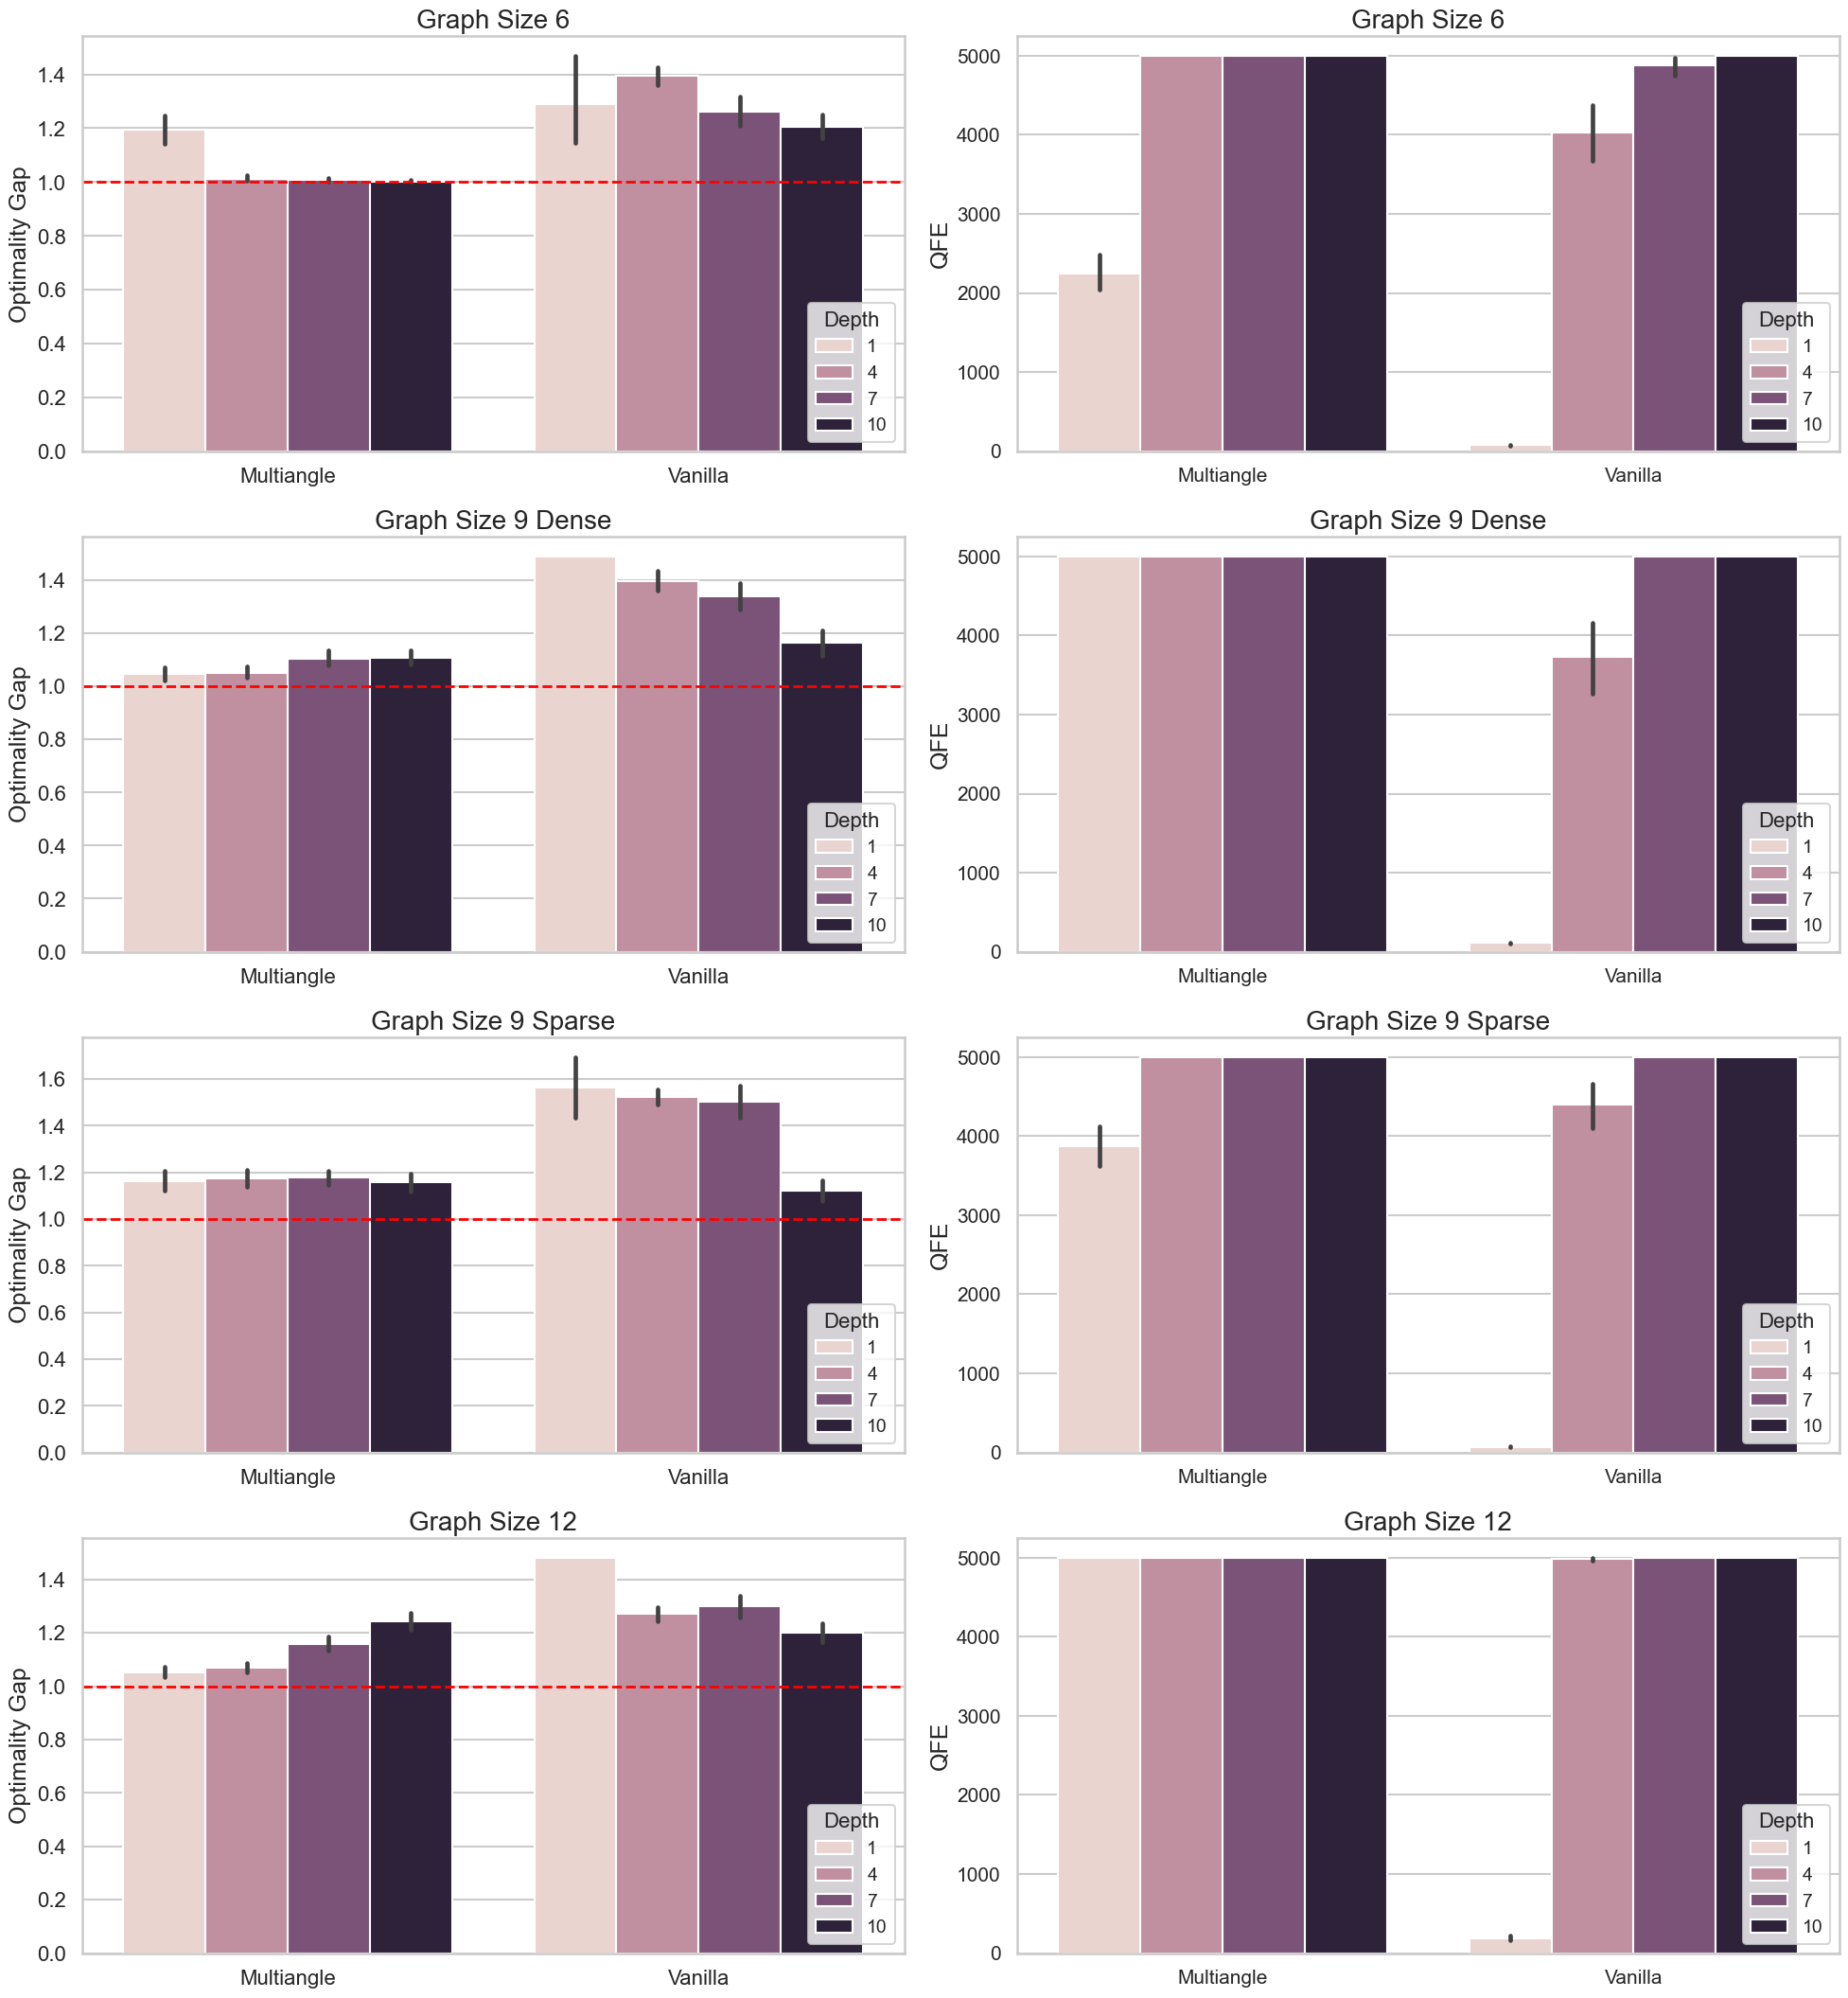

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a copy of results to work with
df = results.copy()
df = df[df['infeasible'] == False]  # Filter out infeasible solutions
df = df[df['warm_start'] == False]  # Filter out warm start solutions
df = df[df['backend_mode'] == 'statevector']

df['depth'] = df['depth'].astype(int)
# Get unique graph names
graph_names = df['graph_name'].unique()

# Create a 4x2 figure for side-by-side comparisons
fig, axes = plt.subplots(4, 2, figsize=(20, 22))

# Left column: Optimality Gap (ratio)
# Right column: Quantum Function Evaluations
for i, graph in enumerate(graph_names):
    # Filter data for this graph
    graph_df = df[df['graph_name'] == graph]
    
    # Get graph size for the title
    graph_size = graph_df['graph_size'].iloc[0]
    
    # Determine graph title
    if graph_size == 9:
        if graph == '>>graph6<<HmzffJz':
            graph_title = f"Graph Size {graph_size:.0f} Dense"
        else:
            graph_title = f"Graph Size {graph_size:.0f} Sparse"
    else:
        graph_title = f"Graph Size {graph_size:.0f}"
    
    # Left plot: Optimality Gap (ratio)
    sns.barplot(data=graph_df, x="qaoa_variant", y="ratio", hue="depth", ax=axes[i, 0])
    axes[i, 0].set_title(f"{graph_title}", fontsize=20)
    axes[i, 0].set_ylabel("Optimality Gap", fontsize=18)
    axes[i, 0].tick_params(axis='both', labelsize=16)
    axes[i, 0].axhline(y=1, color='red', linestyle='--', linewidth=2)
    axes[i, 0].set_xlabel("")
    axes[i, 0].legend(title="Depth", title_fontsize=16, fontsize=14, loc="lower right")
    axes[i, 0].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 0].get_xticklabels()])
    
    # Right plot: QFE
    sns.barplot(data=graph_df, x="qaoa_variant", y="quantum_func_evals", hue="depth", ax=axes[i, 1])
    axes[i, 1].set_title(f"{graph_title}" , fontsize=20)
    axes[i, 1].set_ylabel("QFE", fontsize=18)
    axes[i, 1].tick_params(axis='both', labelsize=15)
    axes[i, 1].set_xlabel("")
    axes[i, 1].legend(title="Depth", title_fontsize=16, fontsize=14, loc="lower right")
    axes[i, 1].set_xticklabels([lbl.get_text().capitalize() for lbl in axes[i, 1].get_xticklabels()])

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for suptitle

# Save figure
plt.savefig('CS_combined_graphs_comparison.pdf', bbox_inches='tight')

plt.show()


Statistics for Quantum Function Evaluations by Graph, QAOA Variant and Depth:

Graph 6 nodes:
  qaoa_variant  depth  count     mean      std   min      25%     50%  \
0   multiangle      1    250  4450.06  1160.93  1187  5000.00  5000.0   
1   multiangle      4    250  5000.00     0.00  5000  5000.00  5000.0   
2   multiangle      7    250  5000.00     0.00  5000  5000.00  5000.0   
3   multiangle     10    250  5000.00     0.00  5000  5000.00  5000.0   
4      vanilla      1    250   273.20   745.99    57    70.25    78.0   
5      vanilla      4    250  3965.11  1426.11   698  3037.50  5000.0   
6      vanilla      7    250  4714.18   696.78  1398  5000.00  5000.0   
7      vanilla     10    250  4996.51    55.21  4127  5000.00  5000.0   

       75%   max  
0  5000.00  5000  
1  5000.00  5000  
2  5000.00  5000  
3  5000.00  5000  
4   128.25  4429  
5  5000.00  5000  
6  5000.00  5000  
7  5000.00  5000  

Graph 9 nodes:
   qaoa_variant  depth  count     mean     std   min      25%

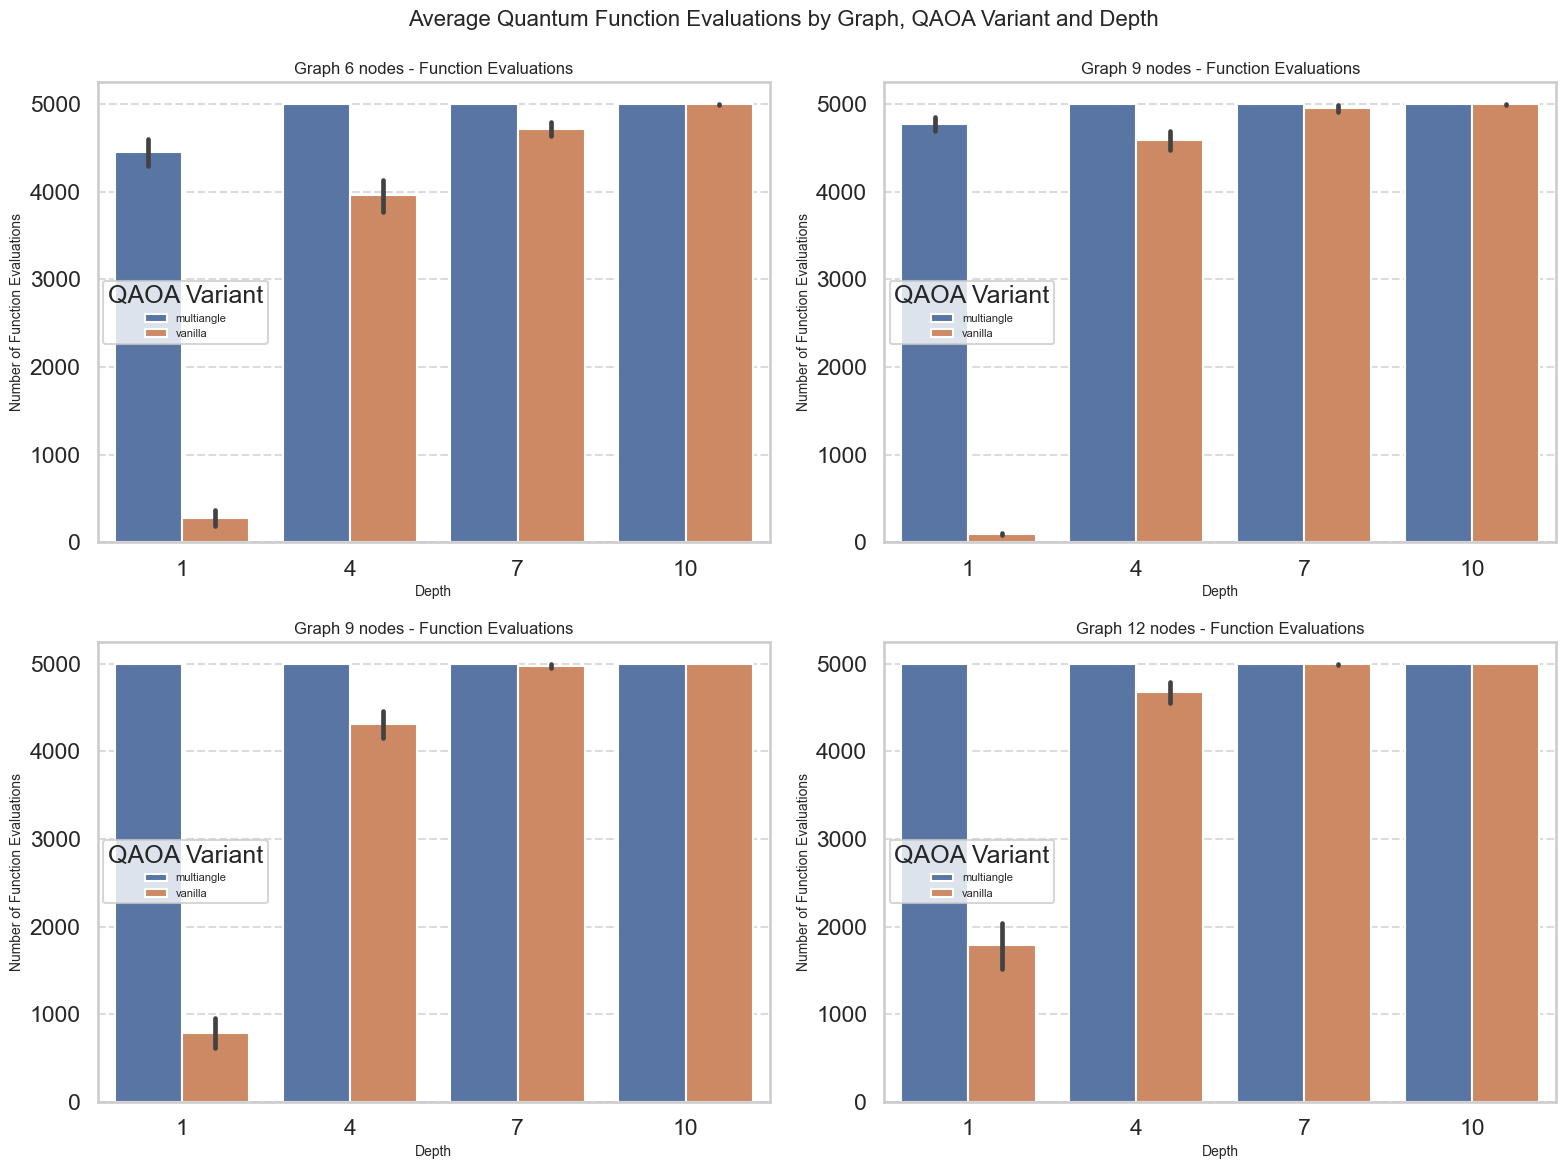

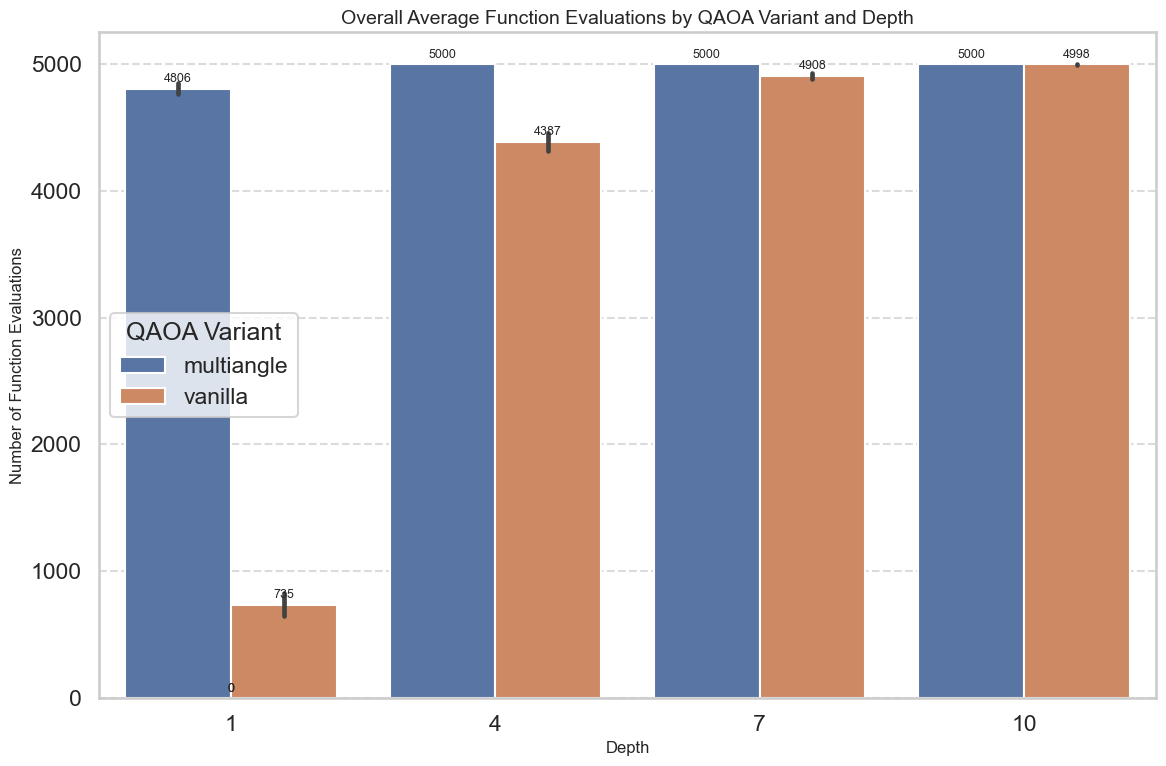

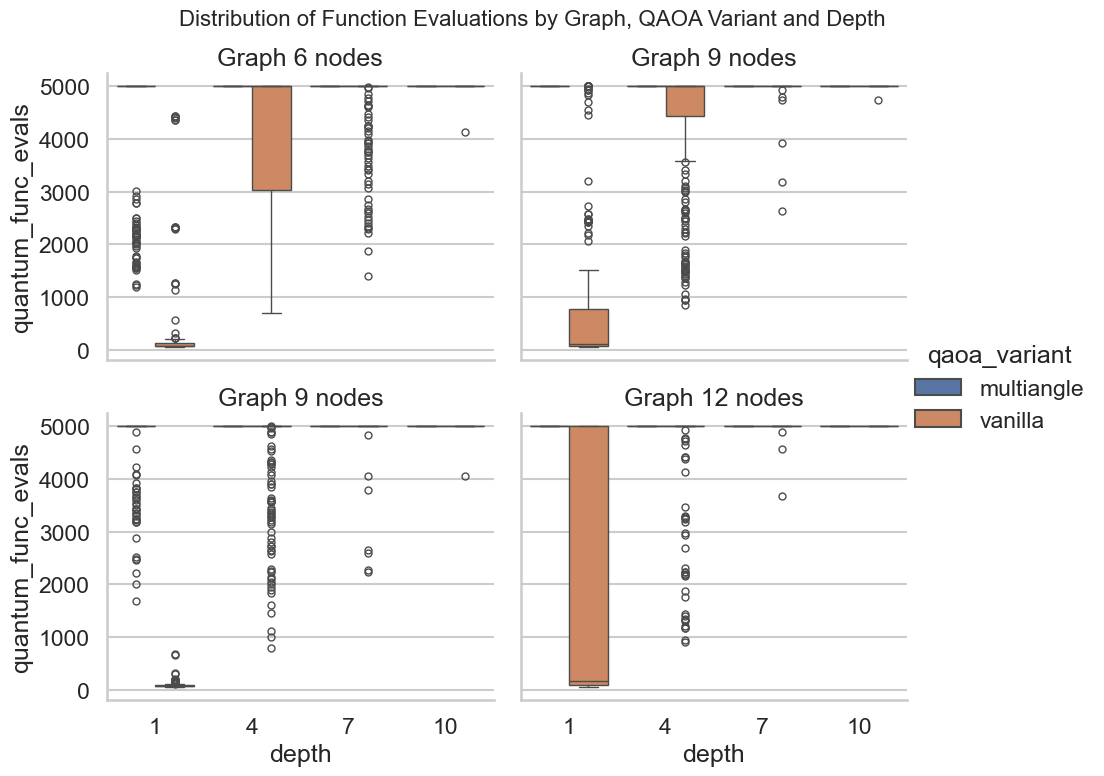

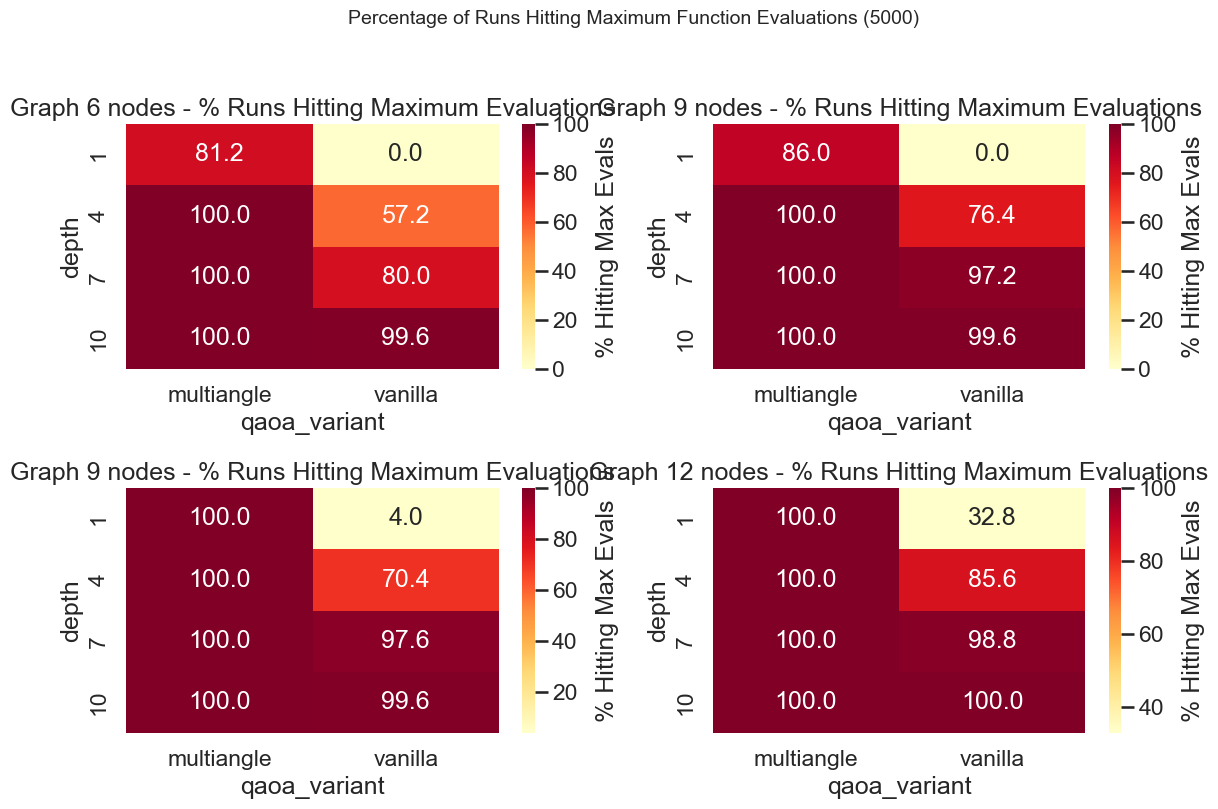


Percentage of Runs Hitting Maximum Function Evaluations (5000):
graph_name          Graph 6 nodes  Graph 9 nodes  Graph 9 nodes  \
qaoa_variant depth                                                
multiangle   1               81.2           86.0          100.0   
             4              100.0          100.0          100.0   
             7              100.0          100.0          100.0   
             10             100.0          100.0          100.0   
vanilla      1                0.0            0.0            4.0   
             4               57.2           76.4           70.4   
             7               80.0           97.2           97.6   
             10              99.6           99.6           99.6   

graph_name          Graph 12 nodes  
qaoa_variant depth                  
multiangle   1               100.0  
             4               100.0  
             7               100.0  
             10              100.0  
vanilla      1                32.8  
     

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = results.copy()
# Calculate statistics for quantum_func_evals grouped by qaoa_variant, depth, and graph_name
stats = df.groupby(['graph_name', 'qaoa_variant', 'depth'])['quantum_func_evals'].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: x.quantile(0.25),  # 25% quartile
    lambda x: x.quantile(0.5),   # median/50% quartile
    lambda x: x.quantile(0.75),  # 75% quartile
    'max'
]).reset_index()

# Rename the lambda function columns to more readable names
stats = stats.rename(columns={
    '<lambda_0>': '25%',
    '<lambda_1>': '50%',
    '<lambda_2>': '75%'
})

# Create a more detailed summary with formatted output
summary_df = stats.copy()
summary_df['mean'] = summary_df['mean'].round(2)
summary_df['std'] = summary_df['std'].round(2)

# Get human-readable graph names for display
graph_sizes = {}
for g_name in summary_df['graph_name'].unique():
    # Extract the graph size from the results DataFrame
    size = df[df['graph_name'] == g_name]['graph_size'].iloc[0]
    graph_sizes[g_name] = f"Graph {size} nodes"

# Print the statistics
print("Statistics for Quantum Function Evaluations by Graph, QAOA Variant and Depth:")
for graph_name in summary_df['graph_name'].unique():
    print(f"\n{graph_sizes[graph_name]}:")
    graph_data = summary_df[summary_df['graph_name'] == graph_name]
    print(graph_data[['qaoa_variant', 'depth', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Create a more visual representation with seaborn - one plot per graph
plt.figure(figsize=(16, 12))
for i, graph_name in enumerate(summary_df['graph_name'].unique()):
    plt.subplot(2, 2, i+1)
    graph_data = df[df['graph_name'] == graph_name]
    sns.barplot(data=graph_data, x='depth', y='quantum_func_evals', hue='qaoa_variant')
    plt.title(f'{graph_sizes[graph_name]} - Function Evaluations', fontsize=12)
    plt.xlabel('Depth', fontsize=10)
    plt.ylabel('Number of Function Evaluations', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='QAOA Variant', fontsize=8)
    plt.tight_layout()

plt.subplots_adjust(top=0.92)
plt.suptitle('Average Quantum Function Evaluations by Graph, QAOA Variant and Depth', fontsize=16)
plt.savefig('func_evals_by_graph.pdf', bbox_inches='tight')
plt.show()

# Combined plot for overall comparison
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='depth', y='quantum_func_evals', hue='qaoa_variant')
plt.title('Overall Average Function Evaluations by QAOA Variant and Depth', fontsize=14)
plt.xlabel('Depth', fontsize=12)
plt.ylabel('Number of Function Evaluations', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='QAOA Variant')

# Add value labels on top of bars
for i, bar in enumerate(plt.gca().patches):
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        bar.get_height() + 50,
        f'{bar.get_height():.0f}',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.savefig('overall_func_evals.pdf', bbox_inches='tight')
plt.show()

# Create faceted boxplot for detailed distribution analysis
g = sns.catplot(
    data=df, 
    x='depth', 
    y='quantum_func_evals', 
    hue='qaoa_variant',
    col='graph_name',
    col_wrap=2,
    kind='box',
    height=4,
    aspect=1.2
)

# Update titles with graph sizes
for i, ax in enumerate(g.axes.flat):
    graph_name = list(graph_sizes.keys())[i]
    ax.set_title(graph_sizes[graph_name])
    
g.fig.suptitle('Distribution of Function Evaluations by Graph, QAOA Variant and Depth', fontsize=16)
g.fig.subplots_adjust(top=0.90)
plt.savefig('func_evals_distribution.pdf', bbox_inches='tight')
plt.show()

# Calculate percentage of runs that hit maximum evaluations (5000)
max_evals_df = results.copy()
max_evals_df['hit_max'] = max_evals_df['quantum_func_evals'] == 5000

# Group by graph, variant and depth and calculate percentage
max_evals_pct = max_evals_df.groupby(['graph_name', 'qaoa_variant', 'depth'])['hit_max'].mean() * 100
max_evals_pct = max_evals_pct.reset_index().rename(columns={'hit_max': 'pct_max_evals'})

# Create a bar plot showing percentage of runs hitting max evaluations
plt.figure(figsize=(12, 8))
for i, graph in enumerate(graph_sizes.keys()):
    plt.subplot(2, 2, i+1)
    graph_data = max_evals_pct[max_evals_pct['graph_name'] == graph]
    
    # Plot heatmap-like grid
    pivot = graph_data.pivot(index='depth', columns='qaoa_variant', values='pct_max_evals')
    sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.1f', cbar_kws={'label': '% Hitting Max Evals'})
    
    plt.title(f'{graph_sizes[graph]} - % Runs Hitting Maximum Evaluations')
    plt.tight_layout()

plt.suptitle('Percentage of Runs Hitting Maximum Function Evaluations (5000)', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('max_evals_percentage.pdf', bbox_inches='tight')
plt.show()

# Summarize in table format for presentation
max_evals_summary = max_evals_pct.pivot_table(
    index=['qaoa_variant', 'depth'], 
    columns='graph_name', 
    values='pct_max_evals'
).round(1)

# Rename columns to be more readable
max_evals_summary = max_evals_summary.rename(columns=graph_sizes)
print("\nPercentage of Runs Hitting Maximum Function Evaluations (5000):")
print(max_evals_summary)